# **Práctica Final de Aprendizaje Automático: predicción de precios de casas de alquiler de Airbnb** 

Por: Bo Miquel Nordfeldt Fiol 

En la siguiente práctica intentaremos generar una inteligencia artificial (que emularia el sistema de recomendación de Airbnb) que intente predecir el precio de alquiler de una casa apartir de sus características. Para ello descargaremos un conjunto de datos de Airbnb, los limpiaremos exhaustivamente, los pre-procesaremos y, finalmente, buscaremos el mejor modelo que nos prediga de forma más exacta el precio.

El código de esta práctica se puede encontrar en el siguiente repositorio: https://github.com/bomiquel/AA_Parte1_airbnb_BoMiquelNordfeldtFiol

In [1]:
# Definición de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import svm

In [271]:
# Funciones auxiliares

def plot_boxplot(X, Y, titulo_plot, titulo_x, titulo_y):
    
    fig = plt.figure()
    plt.figure(figsize = (11, 11))
    ax = sns.boxplot(x = X, y = Y)
    ax.set_ylabel(titulo_y)
    ax.set_xlabel(titulo_x)
    ax.set_title(titulo_plot)
    plt.show()
    
def plot_corrplot(correlacion, titulo_plot):
    
    mask = np.triu(np.ones_like(correlacion, dtype = bool))
    f, ax = plt.subplots(figsize=(11, 11))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)
    sns.heatmap(correlacion, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot=True)
    ax.set_title(titulo_plot)
    plt.show()
    
def predecir_precio(X, y, modelo, titulo, modo):
    
    prediccion = modelo.predict(X)
    print(f'MSE de {titulo} en {modo}: {mean_squared_error(y, prediccion)}')
    #print(f'{titulo} Coeficiente de determinación para {modo}: {r2_score(y, prediccion)}')
    #print(f'{titulo} Root Mean Squared Error para {modo}: {mean_squared_error(y, prediccion, squared = False)}')
    #print(f'{titulo} Mean Absolut Error para entrenamiento para {modo}: {mean_absolute_error(y, prediccion)}')
    
    if modo == 'Entrenamiento':
        df = pd.DataFrame(columns = [modo])
        values_to_add = {'Entrenamiento': mean_squared_error(y, prediccion)}
        row_to_add = pd.Series(values_to_add, name = titulo)
        df = df.append(row_to_add)
    else:
        df = pd.DataFrame(columns = [modo])
        values_to_add = {'Test': mean_squared_error(y, prediccion)}
        row_to_add = pd.Series(values_to_add, name = titulo)
        df = df.append(row_to_add)

    return df 
    
    
    
def cross_validate_farm(X, y, model, titulo, folds):
    
    cross_val_MSE = cross_val_score(estimator = model, X = X, y = y.ravel(), cv = folds, scoring = 'neg_mean_squared_error')
    print(f'MSE de {titulo} en cross validation: {-round(cross_val_MSE.mean(), 8)} +- {round(cross_val_MSE.std(), 8)}')
    #cross_val_R2 = cross_val_score(estimator = model, X = X, y = y.ravel(), cv = folds, scoring = 'r2')
    #print(f'R2 para {titulo}: {round(cross_val_R2.mean(), 8)} +- {round(cross_val_R2.std(), 8)}')
    #cross_val_RMSE = cross_val_score(estimator = model, X = X, y = y.ravel(), cv = folds, scoring = 'neg_root_mean_squared_error')
    #print(f'RMSE para {titulo}: {round(cross_val_RMSE.mean(), 8)} +- {round(cross_val_RMSE.std(), 8)}')
    #cross_val_MAE = cross_val_score(estimator = model, X = X, y = y.ravel(), cv = folds, scoring = 'neg_mean_absolute_error')
    #print(f'MAE para {titulo}: {round(cross_val_MAE.mean(), 8)} +- {round(cross_val_MAE.std(), 8)}')
    
    #df = pd.DataFrame(columns=['MSE', 'R2', 'RMSE', 'MAE'])
    #values_to_add = {'MSE': cross_val_MSE.mean(), 'R2': cross_val_R2.mean(), 'RMSE': cross_val_RMSE.mean(), 'MAE':cross_val_MAE.mean() }
    #row_to_add = pd.Series(values_to_add, name = titulo)
    #df = df.append(row_to_add)
    
    df = pd.DataFrame(columns = ['Cross validation'])
    values_to_add = {'Cross validation': -cross_val_MSE.mean()}
    row_to_add = pd.Series(values_to_add, name = titulo)
    df = df.append(row_to_add)
    
    return df
    

## 1-Visualización y limpieza de datos

### 1.1-Visualización de los datos y primer intento de limpieza

In [3]:
# Primero de todo cargamos los datos del csv en un dataframe:
df_datos_raw = pd.read_csv('airbnb.csv')
df_datos = df_datos_raw.copy() 

In [4]:
# Visualizamos la cabecera de los datos:
pd.set_option('display.max_columns', len(df_datos_raw.columns)) # Para ver todas las columnas
pd.set_option('display.max_rows', 120)
df_datos_raw.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,Daniel,2009-10-02,"Balearic Islands, Spain",.,within an hour,100%,96%,f,https://a0.muscache.com/im/users/42942/profile...,https://a0.muscache.com/im/users/42942/profile...,NaN,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Calvià,NaN,39.51888,2.48182,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",$89.00,5,60,5,5,60,60,5.0,60.0,NaN,t,13,43,73,311,2020-09-21,103,8,2,2011-08-23,2020-09-06,96.0,10.0,9.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,Miguel,2011-04-23,Mallorca,Somos una pareja con los mismos gustos e inter...,NaN,NaN,100%,f,https://a0.muscache.com/im/users/529151/profil...,https://a0.muscache.com/im/users/529151/profil...,NaN,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Santa Margalida,NaN,39.76347,3.16255,Entire house,Entire home/apt,8,NaN,3 baths,4.0,7.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",$175.00,7,365,7,7,1125,1125,7.0,1125.0,NaN,t,0,0,0,0,2020-09-21,30,13,0,2019-01-18,2020-01-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,Bartomeu,2011-05-01,"Ariany, Balearic Islands, Spain",Hola!. Resido en una casa de campo de un puebl...,within a few hours,100%,83%,t,https://a0.muscache.com/im/users/549192/profil...,https://a0.muscache.com/im/users/549192/profil...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Maria de la Salut, Balearic Islands, Spain",Maria de la Salut,NaN,39.66044,3.07165,Entire townhouse,Entire home/apt,6,NaN,2 baths,3.0,4.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",$140.00,6,365,6,6,365,365,6.0,365.0,NaN,t,23,53,83,325,2020-09-20,14,0,0,2012-06-19,2019-09-03,97.0,10.0,10.0,10.0,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14
3,106833,https://www.airbnb.com/rooms/106833,20200919153121,2020-09-20,Villa with a big pool in Mallorca,<b>The space</b><b

In [5]:
# Visualizamos cantidad de filas y columnas
df_datos_raw.shape

(17608, 74)

Como se puede observar estamos ante un dataset muy grande con 74 columnas (que vendrían a ser las variables, *features* o caracterísiticas del *dataset*) y 17608 filas. Además por lo que se puede ver hay muchas de columnas que contiene información poco útil o no aprovechable por una IA sencilla como la que vamos a desarrollar (por ejemplo la columna de *description*). Finalmente, también es posible ver algunos valores nulos. Vamos a empezar la limpieza por ellos.

In [6]:
df_prueba1 = df_datos_raw.dropna()

In [7]:
df_prueba1.shape

(0, 74)

Al eliminar valores nulos con el método *dropna()* se suprimen todas aquellas filas que tengan un valor nulo. Por lo visto todas las filas de nuestro *dataset* tienen uno ya que si consultamos el tamaño del *dataframe* después de aplicarle *.dropna()* encontramos que ahora ya no hay ninguna fila. Por tanto no podemos realizar la limpieza así. 

Por otro lado podemos eliminar nulos por columnas en vez de por filas haciendo *dropna(1)*. Pero de esta manera es posible que eliminemos completamente una columna que nos interesa porque contenga un nulo entre sus valores. Por lo tanto tampoco podemos usar *dropna(1)*.

Así que para realizar la limpieza del *dataset* lo que haremos será eliminar todas las columnas que no aporten información útil y luego, al resultado, aplicaremos *dropna()*. Comenzamos a explorar el *dataset* con detenimiento.

In [8]:
# Visualizamos todos las features (columnas)
df_datos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17608 non-null  int64  
 1   listing_url                                   17608 non-null  object 
 2   scrape_id                                     17608 non-null  int64  
 3   last_scraped                                  17608 non-null  object 
 4   name                                          17607 non-null  object 
 5   description                                   17393 non-null  object 
 6   neighborhood_overview                         8213 non-null   object 
 7   picture_url                                   17608 non-null  object 
 8   host_id                                       17608 non-null  int64  
 9   host_url                                      17608 non-null 

De este resumen de los datos podemos extraer varias conclusiones interesantes. Primero de todo encontramos 3 columnas donde todos sus datos son nulos (*neighbourhood_group_cleansed*, *bathrooms* y *calendar_updated*), estas columnas eran las causantes de que se eliminara todo el *dataset* cuando ejecutabamos: *.dropna()*. Seguidamente, podemos confirmar que hay muchísimas variables con información, a priori, irrelevante y conviene eliminarlas. Finalmente, podemos descubrir que algunas columnas (*features*) tiene los datos en un tipo que no nos interesa. Por ejemplo el precio (*price*) es un objeto en vez de un entero o un *float*.  

Para realizar la limpieza anteriormente descrita empezaremos por transformar el precio en *floats*, estudiar si hay *outliers*, eliminarlos si los encontramos y, finalmente, realizar un estudio de correlación entre todas las variables y el precio. De esta manera podremos averiguar que *features* son relevantes y cuáles no.

### 1.2-Estudio de *outliers*

In [9]:
# Transformación de la columna price de tipo categórico a tipo float
df_datos['price'] = df_datos_raw['price'].str.replace("$","").str.replace(",","").astype(float)

# Nos aseguramos de que hemos hecho bien la transformación
df_datos['price'].dtype

dtype('float64')

In [10]:
# Estudio de outliers: describe()
df_datos['price'].describe()

count    17608.000000
mean       244.383561
std        409.958169
min          0.000000
25%        110.000000
50%        179.000000
75%        275.000000
max      20736.000000
Name: price, dtype: float64

Solo mirando la descripción de los datos ya podemos ver que hay *outliers*. El tercer cuartil (el 75% de los datos) tiene un valor muy bajo en comparación al valor màximo de todo el *dataset*, la media se encuentra desplazada y no esta cerca del segundo cuartil y, finalmente, la desviación estándar es muy grande. Vamos a realizar un *boxplot* para visualizar la distribución de los datos y confirmar que hay *outliers* (aunque es muy probable que los haya).

<Figure size 432x288 with 0 Axes>

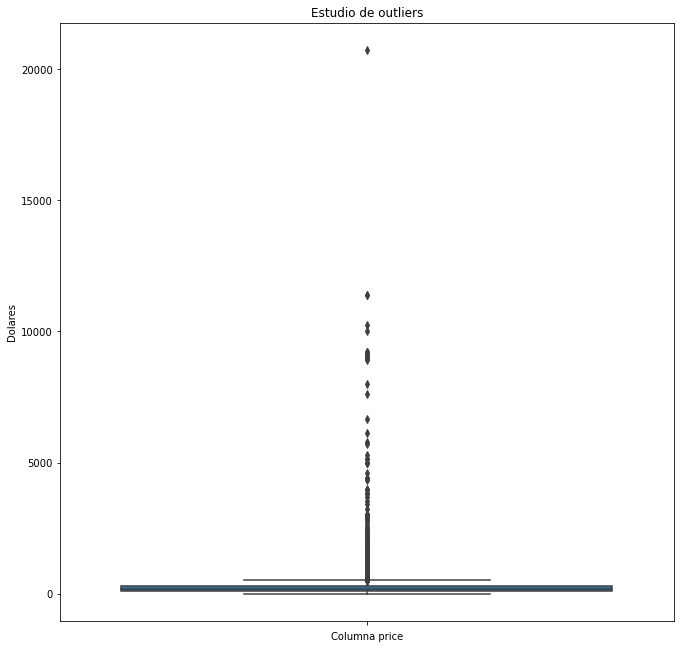

In [11]:
# Estudio de outliers: boxplot
plot_boxplot(None, df_datos['price'], 'Estudio de outliers', 'Columna price', 'Dolares')

<Figure size 432x288 with 0 Axes>

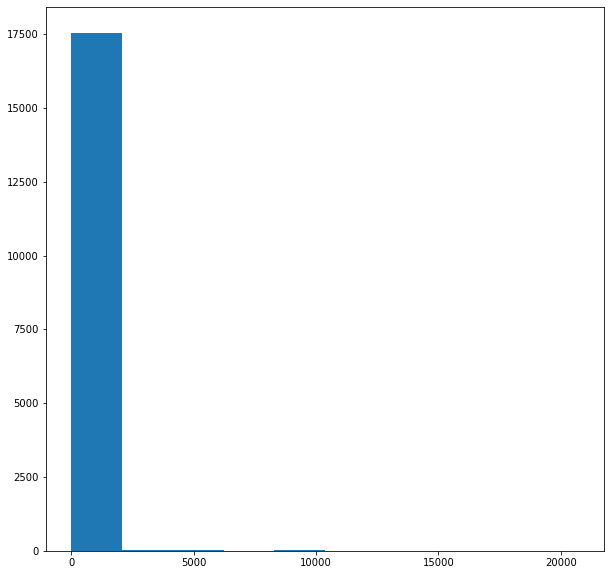

In [12]:
fig = plt.figure()
plt.figure(figsize = (10, 10))
plt.hist(x = df_datos['price'])
plt.show()

Con la visualización del boxplot ya podemos confirmar que hay *outliers* y con el histograma podemos ver que los datos no estan normalizados. Como la diferencia de precio entre cuartiles parece ir de 100 dolares en 100 dolares vamos a suponer que el 100% de los datos deberían estar por debajo de 375 dolares.

In [13]:
df_datos_precio_limpio = df_datos.drop(df_datos[df_datos['price'] > 375].index)

In [14]:
df_datos_precio_limpio['price'].describe()

count    15272.000000
mean       168.809671
std         85.074517
min          0.000000
25%        100.000000
50%        160.000000
75%        227.000000
max        375.000000
Name: price, dtype: float64

<Figure size 432x288 with 0 Axes>

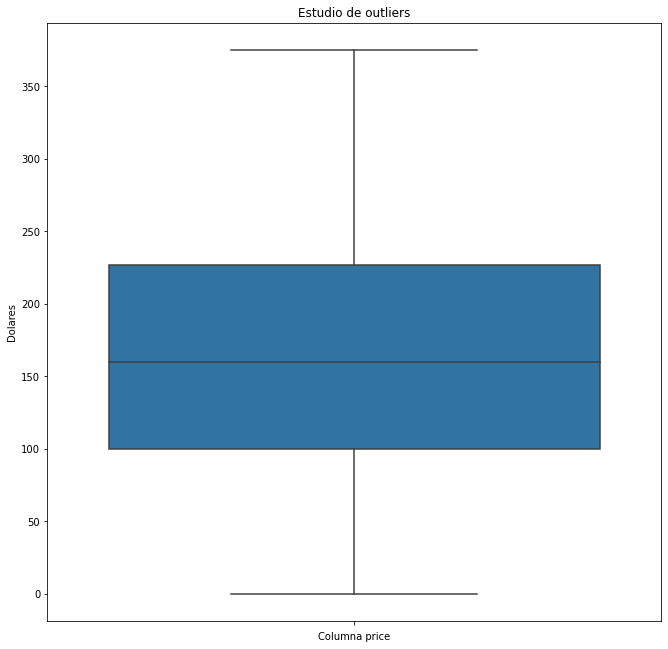

In [15]:
plot_boxplot(None, df_datos_precio_limpio['price'], 'Estudio de outliers', 'Columna price', 'Dolares')

<Figure size 432x288 with 0 Axes>

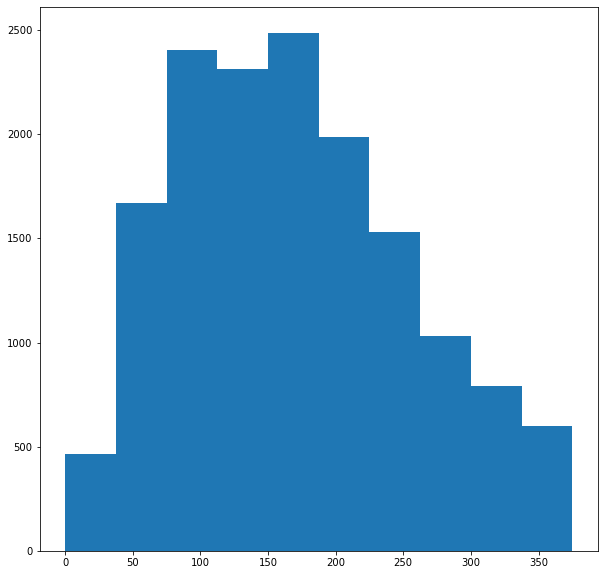

In [16]:
fig = plt.figure()
plt.figure(figsize = (10, 10))
plt.hist(x=df_datos_precio_limpio['price'])
plt.show()

In [17]:
df_datos_precio_limpio.shape

(15272, 74)

In [18]:
len(df_datos_raw) - len(df_datos_precio_limpio)

2336

Una vez eliminados los *outliers* podemos observar como la media es mucho más cercana al segundo cuartil, los datos estan distribuidos más uniformemente y la desviación estándar es mucho más baja. Por tanto hemos conseguido una mejoría notable en la distribución de los datos. Sin embargo, hemos perdido por el camino 2336 filas. Hay que ir con cuidado con la limpieza porque nos podemos quedar sin datos.

### 1.3- Estudio de correlación y filtrado de datos

#### 1.3.1-Primer filtraje

A continuación realizaremos un estudio de correlación entre todas las variables y el precio.

In [19]:
# Calculamos una primera correlación
correlacion_variables_precio_1 = df_datos_precio_limpio[df_datos_precio_limpio.columns[0:]].corr()['price'][:]
correlacion_variables_precio_1

id                                              1.658307e-02
scrape_id                                       1.468932e-15
host_id                                        -9.698539e-02
host_listings_count                             1.713384e-01
host_total_listings_count                       1.713384e-01
neighbourhood_group_cleansed                             NaN
latitude                                        1.368835e-01
longitude                                       1.685263e-01
accommodates                                    6.126296e-01
bathrooms                                                NaN
bedrooms                                        5.639530e-01
beds                                            5.052249e-01
price                                           1.000000e+00
minimum_nights                                 -1.738203e-03
maximum_nights                                  9.256358e-02
minimum_minimum_nights                          1.297894e-02
maximum_minimum_nights  

In [20]:
len(correlacion_variables_precio_1)

41

Como se puede observar el estudio de correlacion no se ha realizado completamente ya que muchas de las variables son de tipo categórico y no se pueden obtener una correlación entre ellas y el precio (el cual es un *float*). Para solventar este problema vamos a eliminar todas las columnas de tipo categórico que intuitivamente nos parezcan poco útiles y también aprovecharemos para empezar a realizar un primer filtrado de las variables númericas que no tienen una buena correlación con el precio.

De todo el conjunto podemos eliminar las siguientes *features*:
+ *id* (Es una variable númerica pero no nos aporta información relevante su valor de correlación es del orden de 10 elevado a menos dos. Además el índice de la fila del *dataframe* ya nos basta para identificar la casa)
+ *listing_url* (Variable categórica. Es una URL y para predecir el precio de la casa no es útil) 
+ *scrape_id* (Identificador del *scrape*, no es útil ya que tiene una correlación con el precio de 10 elevado a menos 15 y además si nos fijamos es el mismo valor siempre)
+ *last_scraped* (Es la fecha de cuando se hizo el *scrape*, no interesa)
+ *name* (Cadenas de strings muy largas y difíciles de pre-procesar)
+ *description* (Cadenas de *strings* muy largas y difíciles de pre-procesar)
+ *neighborhood_overview* (Cadenas de *strings* muy largas y difíciles de pre-procesar además la columna contiene muchos nulos)
+ *picture_url* (Más URL que la IA no puede utilizar)
+ *host_id* (Correlación muy baja con el precio, del orden de 10 elevado a menos 3)
+ *host_url* (Más URL's, también se puede eliminar)
+ *host_name* (El nombre del propietario no influye en el precio de la vivienda)
+ *host_since* (La fecha en la que el propietario adquirio la casa no influye en el precio de la vivienda)
+ *host_location* (Donde resida el propietario tampoco influye en el precio de la vivienda que alquila) 
+ *host_about* (Cadenas de *strings* muy largas y difíciles de pre-procesar)
+ *host_response_time* (El tiempo de respuesta del propietario no influye en el precio que pone él a su casa)
+ *host_response_rate* (Si el propietario contesta siempre tampoco influye en el precio)
+ *host_acceptance_rate* (Si nos quedamos con la columna de superhost esta no es necesaria)
+ *host_thumbnail_url* (Más URL's)
+ *host_picture_url* (Más URL's)
+ *host_neighbourhood* (La columna contiene demasiados valores nulos)
+ *host_verifications* (Lista de métodos de verificación del host, es un poco redundante si se tiene la columna *host_identity_verified*)
+ *neighbourhood* (Demasiados valores nulo)
+ *neighbourhood_group_cleansed* (Todos los datos de la columna son valores nulos)
+ *bathrooms* (Todos los datos de la columna son valores nulos)
+ *minimum_nights* (Correlación muy baja, menor que 0,1) 
+ *maximum_nights* (Correlación muy baja, menor que 0,1) 
+ *minimum_minimum_nights* (Correlación muy baja, menor que 0,1)
+ *maximum_minimum_nights* (Correlación muy baja, menor que 0,1)
+ *minimum_maximum_nights* (Correlación muy baja, menor que 0,1)
+ *maximum_maximum_nights* (Correlación muy baja, menor que 0,1)
+ *minimum_nights_avg_ntm* (Correlación muy baja, menor que 0,1)
+ *maximum_nights_avg_ntm* (Correlación muy baja, menor que 0,1)
+ *calendar_updated* (Toda la columna son valores nulos)
+ *has_availability* (No estamos interesados en información que puede cambiar diariamente)
+ *availability_30* (No estamos interesados en información que puede cambiar diariamente. Además la correlación es muy baja, menor que 0,1)
+ *availability_60* (No estamos interesados en información que puede cambiar diariamente. Además la correlación es muy baja, menor que 0,1)
+ *availability_90* (No estamos interesados en información que puede cambiar diariamente. Además la correlación es muy baja, menor que 0,1)
+ *availability_365* (No estamos interesados en información que puede cambiar diariamente. Además la correlación es muy baja, menor que 0,1)
+ *calendar_last_scraped* (Como se ha dicho anteriormente no estamos interesados en el *scrape*)
+ *first_review* (Fecha del primer comentario, no es relevante)
+ *last_review* (Fecha del último comentario, no es relevante)
+ *review_scores_rating* (Correlación muy baja, menor que 0,1)
+ *review_scores_accuracy* (Correlación muy baja, menor que 0,1)
+ *review_scores_cleanliness* (Correlación muy baja, menor que 0,1)
+ *review_scores_checkin* (Correlación muy baja, menor que 0,1)
+ *review_scores_communication* (Correlación muy baja, menor que 0,1) 
+ *review_scores_location* (Correlación muy baja, menor que 0,1)
+ *review_scores_value* (Correlación muy baja, menor que 0,1)
+ *license* (Tipo de licencias, no es interesante para saber el precio)
+ *instant_bookable* (No estamos interesados en información que puede cambiar diariamente.)
+ *calculated_host_listings_count_private_rooms* (Correlación muy baja, menor que 0,1)
+ *calculated_host_listings_count_shared_rooms* (Correlación muy baja, menor que 0,1)




Nos quedamos con las siguientes columnas: 
+ *host_is_superhost* (Variable para saber lo bueno que es un host, habrá que transformarla de caracteres a booleanos. A mayor calidad del host mayor precio se le puede dar a la vivienda)
+ *host_listings_count* (Correlación superior a 0,1)
+ *host_total_listings_count* (Correlación superior a 0,1)
+ *host_identity_verified* (Variable para saber lo fiable que es un host, habrá que transformarla de caracteres a booleanos. A mayor fiabilidad mayor precio se le puede dar a la vivienda)
+ *host_has_profile_pic* (Variable para saber lo fiable que es un host, habrá que transformarla de caracteres a booleanos. A mayor fiabilidad mayor precio se le puede dar a la vivienda)
+ *neighbourhood_cleansed* (Variable para saber donde esta la vivienda. Hay que pasar de una columna categorica a x columnas de booleanos)
+ *latitude* (Variable necesaria para saber donde se encuentra la casa. Hay sitios mejores que otros, por tanto en los mejores sitios las casas pueden ser más caras)
+ *longitude* (Variable necesaria para saber donde se encuentra la casa. Hay sitios mejores que otros, por tanto en los mejores sitios las casas pueden ser más caras)
+ *property_type* (El tipo de vivienda influye en el precio. Hay que pasar de una columna categorica a x columnas de booleanos) 
+ *room_type* (El tipo de habitación influe en el precio. Hay que pasar de una columna categorica a x columnas de booleanos) 
+ *accommodates* (Variable que describe la propiedad, su correlación es superior a 0,1)
+ *bathrooms_text* (Variable que describe la propiedad. Hay que cambiarla de categórica a número)
+ *bedrooms* (Variable que describe la propiedad, su correlación es superior a 0,1)
+ *beds* (Variable que describe la propiedad, su correlación es superior a 0,1)
+ *amenities* (Variable que describe la propiedad. Hay que pasar de una columna categorica a x columnas de booleanos)
+ *price* (Objetivo deseado)
+ *number_of_reviews_ltm* (Correlación superior a 0,1)
+ *number_of_reviews* (Correlación superior a 0,1)
+ *number_of_reviews_l30d* (Correlación superior a 0,1)
+ *calculated_host_listings_count* (Número de propiedades que tiene un host, correlación superior a 0,1)
+ *calculated_host_listings_count_entire_homes* (Número de propiedades enteras que tiene un host, correlación superior a 0,1)
+ *reviews_per_month* (Correlación superior a 0,1)

Algunas de ellas deberemos tratarlas más adelante (y a lo mejor eliminarlas) y otras a lo mejor las eliminaremos por ser redundantes.

**NOTA:** A la hora de analizar cada variable hemos consultado que había en cada columna usando *df_datos_precio_limpio[[]]* y *df_datos_precio_limpio[[]].unique()* (además de mirar las correlaciones). No esta detallado todo el proceso porque sino el documento sería demasiado extenso.

In [21]:
# Generamos el nuevo dataframe con las columnas seleccionadas:
df_datos_primer_filtro = df_datos_precio_limpio[['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'host_has_profile_pic', 'neighbourhood_cleansed', 'latitude', 
                                                 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'number_of_reviews_ltm', 'number_of_reviews', 
                                                'number_of_reviews_l30d', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'reviews_per_month']]

Una vez que tenemos montado el *dataframe* del primer filtraje podemos pasar a analizarlo:

In [22]:
# Análisis del dataframe filtrado:
df_datos_primer_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   host_is_superhost                            15270 non-null  object 
 1   host_listings_count                          15270 non-null  float64
 2   host_total_listings_count                    15270 non-null  float64
 3   host_identity_verified                       15270 non-null  object 
 4   host_has_profile_pic                         15270 non-null  object 
 5   neighbourhood_cleansed                       15272 non-null  object 
 6   latitude                                     15272 non-null  float64
 7   longitude                                    15272 non-null  float64
 8   property_type                                15272 non-null  object 
 9   room_type                                    15272 non-null  object 
 10

Si observamos los resultados del análisis del *dataframe* filtrado podemos ver que nos hemos quedado con 22 variables (columnas), 14 de las cuáles son numéricas y 8 son categoricas. También es posible notar que una de las columnas (*reviews_per_month*) tiene 10106 valores no nulos, es decir que tiene 5166 valores nulos. Como perder aproximadamente un tercio de los valores sería desastroso vamos a eliminar esta variable.

In [23]:
df_datos_primer_filtro = df_datos_primer_filtro.drop(labels='reviews_per_month', axis=1)

In [24]:
df_datos_primer_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   host_is_superhost                            15270 non-null  object 
 1   host_listings_count                          15270 non-null  float64
 2   host_total_listings_count                    15270 non-null  float64
 3   host_identity_verified                       15270 non-null  object 
 4   host_has_profile_pic                         15270 non-null  object 
 5   neighbourhood_cleansed                       15272 non-null  object 
 6   latitude                                     15272 non-null  float64
 7   longitude                                    15272 non-null  float64
 8   property_type                                15272 non-null  object 
 9   room_type                                    15272 non-null  object 
 10

Seguidamente, para acabar de limpiar los datos (quitar variables redundantes, transformar variables categoricas en numéricas...) de forma más comóda y para no cometer errores vamos a separar el *dataframe* en dos: uno de tipo numérico y el otro de tipo catgórico. 

In [25]:
df_datos_primer_filtro_numero = df_datos_primer_filtro.select_dtypes(include=[np.number]).copy()
df_datos_primer_filtro_categorico = df_datos_primer_filtro.select_dtypes(include=[object]).copy()

Podemos ver sus resumenes a continuación:

In [26]:
df_datos_primer_filtro_numero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   host_listings_count                          15270 non-null  float64
 1   host_total_listings_count                    15270 non-null  float64
 2   latitude                                     15272 non-null  float64
 3   longitude                                    15272 non-null  float64
 4   accommodates                                 15272 non-null  int64  
 5   bedrooms                                     15010 non-null  float64
 6   beds                                         15192 non-null  float64
 7   price                                        15272 non-null  float64
 8   number_of_reviews_ltm                        15272 non-null  int64  
 9   number_of_reviews                            15272 non-null  int64  
 10

In [27]:
df_datos_primer_filtro_categorico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_is_superhost       15270 non-null  object
 1   host_identity_verified  15270 non-null  object
 2   host_has_profile_pic    15270 non-null  object
 3   neighbourhood_cleansed  15272 non-null  object
 4   property_type           15272 non-null  object
 5   room_type               15272 non-null  object
 6   bathrooms_text          15264 non-null  object
 7   amenities               15272 non-null  object
dtypes: object(8)
memory usage: 1.0+ MB


#### 1.3.2- Segundo filtraje. Variables numéricas 

Empezaremos trabajando con las variables numéricas. Para ello miramos la correlación de todas las variables con el precio:

In [28]:
# Miramos la correlación de las variables numéricas con el valor del precio:
correlacion_variables_precio_2 = df_datos_primer_filtro_numero[df_datos_primer_filtro_numero.columns[0:]].corr()['price'][:]
correlacion_variables_precio_2

host_listings_count                            0.171338
host_total_listings_count                      0.171338
latitude                                       0.136883
longitude                                      0.168526
accommodates                                   0.612630
bedrooms                                       0.563953
beds                                           0.505225
price                                          1.000000
number_of_reviews_ltm                         -0.316482
number_of_reviews                             -0.293784
number_of_reviews_l30d                        -0.271084
calculated_host_listings_count                 0.173344
calculated_host_listings_count_entire_homes    0.174763
Name: price, dtype: float64

Si ahora nos fijamos en las correlaciones obtenidas podemos ver que hay algunas variables con nombres similares o con significado parecido que tienen unas correlaciones con el precio muy similares, por tanto es posible que estas variables sean redundantes. Para averiguar si lo son o no deberemos ver si entre ellas estan muy correlacionadas. Entenderemos que dos variables son redundantes cuando su correlación sea igual o superior a 0,75.

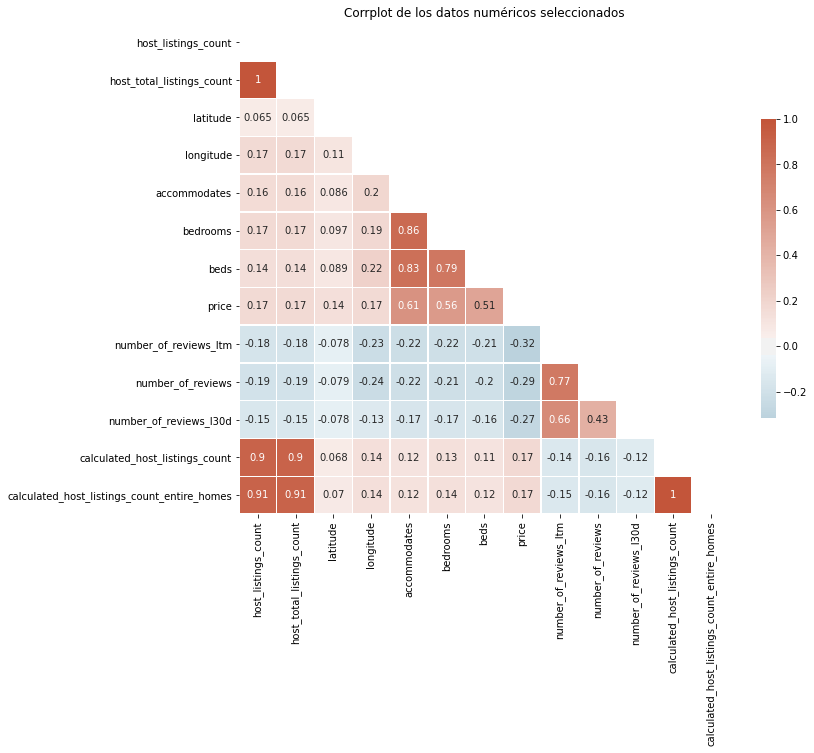

In [29]:
corr = df_datos_primer_filtro_numero.corr()

plot_corrplot(corr, 'Corrplot de los datos numéricos seleccionados')

Parece ser que las variables: *host_listings_count*, *host_total_listings_count*, *calculated_host_listings_count* y *calculated_host_listings_count_entire_homes* tienen mucha correlación entre ellas y por tanto las 4 son redundantes. Nos quedaremos con una de ellas: *calculated_host_listings_count_entire_homes* ya que es la que tiene ligeramente más correlación con el precio de alquiler de la vivienda.

Tenemos una situación similar con *bedrooms*, *beds* y *accommodates*. Las tres tienen mucha correlación entre sí por tanto eliminaremos dos y nos quedaremos con una, *accommodates* (ya que es la que tiene mayor correlación con el precio).

Finalmente, encontramos el mismo caso entre *number_of_reviews* y *number_of_reviews_ltm*. Como *number_of_reviews_ltm* tiene mayor correlación con el precio nos quedaremos con esta variable.

In [30]:
df_datos_primer_filtro_numero = df_datos_primer_filtro_numero.drop(labels=['host_listings_count','host_total_listings_count', 'calculated_host_listings_count', 'bedrooms', 'beds', 'number_of_reviews'], axis=1)

El resultado es el siguiente:

In [31]:
df_datos_primer_filtro_numero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   latitude                                     15272 non-null  float64
 1   longitude                                    15272 non-null  float64
 2   accommodates                                 15272 non-null  int64  
 3   price                                        15272 non-null  float64
 4   number_of_reviews_ltm                        15272 non-null  int64  
 5   number_of_reviews_l30d                       15272 non-null  int64  
 6   calculated_host_listings_count_entire_homes  15272 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 954.5 KB


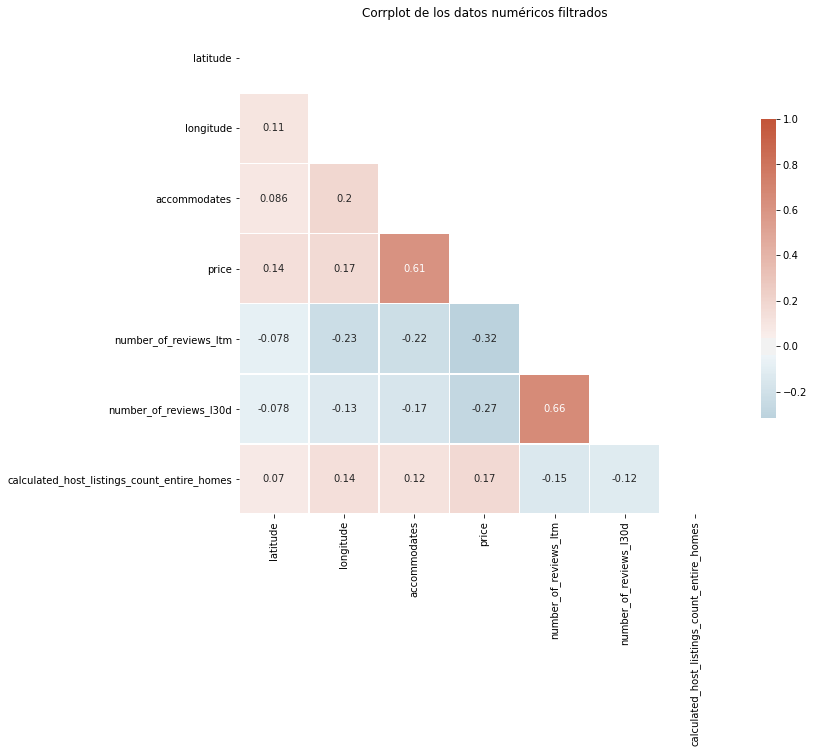

In [32]:
corr = df_datos_primer_filtro_numero.corr()

plot_corrplot(corr, 'Corrplot de los datos numéricos filtrados')

In [33]:
# Miramos la correlación de las variables numéricas con el valor del precio:
correlacion_variables_precio_3 = df_datos_primer_filtro_numero[df_datos_primer_filtro_numero.columns[0:]].corr()['price'][:]
correlacion_variables_precio_3

latitude                                       0.136883
longitude                                      0.168526
accommodates                                   0.612630
price                                          1.000000
number_of_reviews_ltm                         -0.316482
number_of_reviews_l30d                        -0.271084
calculated_host_listings_count_entire_homes    0.174763
Name: price, dtype: float64

Una vez limpiadas correctamente las variables numéricas podemos pasar a tratar las variables categóricas. 

#### 1.3.3-Segundo filtraje. Variables categóricas

In [34]:
df_datos_primer_filtro_categorico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_is_superhost       15270 non-null  object
 1   host_identity_verified  15270 non-null  object
 2   host_has_profile_pic    15270 non-null  object
 3   neighbourhood_cleansed  15272 non-null  object
 4   property_type           15272 non-null  object
 5   room_type               15272 non-null  object
 6   bathrooms_text          15264 non-null  object
 7   amenities               15272 non-null  object
dtypes: object(8)
memory usage: 1.0+ MB


Vamos a recordar los valores de cada columna mediante un *.head()* del *dataframe*.

In [35]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities
0,f,t,t,Calvià,Entire apartment,Entire home/apt,1 bath,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s..."
1,f,t,t,Santa Margalida,Entire house,Entire home/apt,3 baths,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe..."
2,t,t,t,Maria de la Salut,Entire townhouse,Entire home/apt,2 baths,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac..."
3,f,t,t,Sant Llorenç des Cardassar,Entire villa,Entire home/apt,1 bath,"[""Pool"", ""Free parking on premises"", ""Air cond..."
4,f,f,t,Palma de Mallorca,Private room in apartment,Private room,1 bath,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche..."


El contenido de las tres primeras variables (*host_is_superhost*, *host_identity_verified*, *host_identity_verified* ) son t's y f's, que significan *true* y *false*. Debemos cambiar estos caracteres por 1 y 0. *neighbourhood_cleansed*, *property_type*, *room_type* y *amenities* contienen listas de *strings* que hay que transformar (cada *string*) o agrupar en classes afines y luego transformar en columnas que se rellenaran con valores booleanos. En otras palabras, hay que realizar *One-Hot Encoding* con los valores de estas columnas. Finalmente, en la variable *bathrooms_text* encontramos, siempre, un número seguido de una *string*. En esta columna solo debemos eliminar la *string* y dejar el número.

Vamos a empezar por transformar los carácteres de *host_is_superhost*, *host_identity_verified*, *host_identity_verified*  en booleanos:

In [36]:
columnas_booleanas = ['host_is_superhost','host_identity_verified','host_has_profile_pic']

for col in columnas_booleanas:
    df_datos_primer_filtro_categorico[col] = df_datos_primer_filtro_categorico[col].replace('f', 0)
    df_datos_primer_filtro_categorico[col] = df_datos_primer_filtro_categorico[col].replace('t', 1)

Observamos el resultado:

In [37]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities
0,0.0,1.0,1.0,Calvià,Entire apartment,Entire home/apt,1 bath,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s..."
1,0.0,1.0,1.0,Santa Margalida,Entire house,Entire home/apt,3 baths,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe..."
2,1.0,1.0,1.0,Maria de la Salut,Entire townhouse,Entire home/apt,2 baths,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac..."
3,0.0,1.0,1.0,Sant Llorenç des Cardassar,Entire villa,Entire home/apt,1 bath,"[""Pool"", ""Free parking on premises"", ""Air cond..."
4,0.0,0.0,1.0,Palma de Mallorca,Private room in apartment,Private room,1 bath,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche..."


Seguimos con la transformación de los datos de los baños:

In [38]:
df_datos_primer_filtro_categorico['bathrooms'] = df_datos_primer_filtro_categorico['bathrooms_text'].str.extract('(\d+)').astype(float)
df_datos_primer_filtro_categorico = df_datos_primer_filtro_categorico.drop(labels='bathrooms_text', axis=1)

Observamos el resultado:

In [39]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,neighbourhood_cleansed,property_type,room_type,amenities,bathrooms
0,0.0,1.0,1.0,Calvià,Entire apartment,Entire home/apt,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",1.0
1,0.0,1.0,1.0,Santa Margalida,Entire house,Entire home/apt,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",3.0
2,1.0,1.0,1.0,Maria de la Salut,Entire townhouse,Entire home/apt,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",2.0
3,0.0,1.0,1.0,Sant Llorenç des Cardassar,Entire villa,Entire home/apt,"[""Pool"", ""Free parking on premises"", ""Air cond...",1.0
4,0.0,0.0,1.0,Palma de Mallorca,Private room in apartment,Private room,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",1.0


Por ahora estas transformaciones de valores categoricos a numéricos han sido sencillas. Sin embargo, las columnas restantes contienen muchos valores diferentes cada una y eso podría complicar las cosas. Vamos a visualizar los posibles valores y a analizarlos: 

In [40]:
df_datos_primer_filtro_categorico['property_type'].unique()

array(['Entire apartment', 'Entire house', 'Entire townhouse',
       'Entire villa', 'Private room in apartment', 'Entire guesthouse',
       'Private room in guest suite', 'Private room in villa',
       'Entire loft', 'Entire cottage', 'Entire condominium',
       'Room in boutique hotel', 'Private room', 'Private room in house',
       'Entire chalet', 'Entire cabin', 'Private room in condominium',
       'Entire guest suite', 'Private room in cottage', 'Camper/RV',
       'Boat', 'Private room in townhouse', 'Private room in hostel',
       'Private room in bed and breakfast', 'Entire serviced apartment',
       'Private room in guesthouse', 'Shared room in apartment',
       'Farm stay', 'Room in serviced apartment',
       'Room in bed and breakfast', 'Private room in chalet',
       'Entire bungalow', 'Room in hotel', 'Island',
       'Shared room in igloo', 'Shared room in bed and breakfast',
       'Castle', 'Entire bed and breakfast', 'Entire place',
       'Room in aparthot

In [41]:
len(df_datos_primer_filtro_categorico['property_type'].unique())

73

In [42]:
df_datos_primer_filtro_categorico['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [43]:
df_datos_primer_filtro_categorico['neighbourhood_cleansed'].unique()

array(['Calvià', 'Santa Margalida', 'Maria de la Salut',
       'Sant Llorenç des Cardassar', 'Palma de Mallorca', 'Selva',
       'Esporles', 'Banyalbufar', 'Manacor', 'Sa Pobla', 'Alcúdia',
       'Pollença', 'Artà', 'Santanyí', 'Campos', 'Llucmajor', 'Sineu',
       'Lloseta', 'Marratxí', 'Felanitx', 'Llubí', 'Muro',
       'Lloret de Vistalegre', 'Ariany', 'Campanet', 'Capdepera',
       'Puigpunyent', 'Binissalem', 'Valldemossa', 'Algaida',
       'Son Servera', 'Sóller', 'Fornalutx', 'Ses Salines',
       'Mancor de la Vall', 'Andratx', 'Santa María del Camí', 'Inca',
       'Costitx', 'Deyá', 'Búger', 'Porreres', 'Alaró', 'Montuïri',
       'Escorca', 'Petra', 'Consell', 'Sencelles', 'Bunyola',
       'Vilafranc de Bonany', 'Estellencs', 'Sant Joan', 'Santa Eugènia'],
      dtype=object)

In [44]:
len(df_datos_primer_filtro_categorico['neighbourhood_cleansed'].unique())

53

In [45]:
df_datos_primer_filtro_categorico['amenities'].unique()

array(['["Oven", "Wifi", "Coffee maker", "Dishes and silverware", "Essentials", "Kitchen", "TV", "Cooking basics", "Refrigerator", "Shampoo", "Microwave", "Pool", "Beachfront", "Free parking on premises", "Free street parking", "Air conditioning", "Host greets you", "Elevator", "Hot water", "Patio or balcony", "Stove", "Washer", "Heating"]',
       '["First aid kit", "Hair dryer", "Iron", "Washer", "Free street parking", "Air conditioning", "Essentials", "Hangers", "Smoke alarm", "Indoor fireplace", "Carbon monoxide alarm", "Kitchen", "Wifi", "Laptop-friendly workspace", "TV", "Cable TV", "Coffee maker", "Dishes and silverware", "Fire extinguisher", "Shampoo"]',
       '["Smoke alarm", "Oven", "Wifi", "Garden or backyard", "Coffee maker", "Dishes and silverware", "Fire extinguisher", "First aid kit", "Essentials", "Dishwasher", "Carbon monoxide alarm", "Kitchen", "TV", "Cooking basics", "Refrigerator", "Microwave", "Pool", "Hair dryer", "Iron", "Crib", "High chair", "Air conditioning",

Con *.unique()* no conseguimos aclarar que valores hay, habrá que tratar el *feature* un poco más: 

In [46]:
# Tratamiento de la columna amenities para ver sus valores:
amenities_list = list(df_datos_primer_filtro_categorico['amenities'])
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '52\\ HDTV',
 'Air conditioning',
 'Airport shuttle',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Barbecue utensils',
 'Bathtub',
 'Beach',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bed sheets and pillows',
 'Bluetooth speaker',
 'Body soap',
 'Bose sound system',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Cable TV',
 'Carbon monoxide alarm',
 'Ceiling fan',
 'Changing table',
 'Children\\u2019s books and toys',
 'Children\\u2019s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Complimentary continental breakfast',
 'Conditioner',
 'Cooking basics',
 'Crib',
 'Dishes and silverware',
 'Dishwasher',
 'Dryer',
 'EV charger',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Fire extinguisher',
 'Fireplace guards',
 'First aid kit',
 'Free parking on premises',
 'Free street parking',
 'Free wifi',
 'Freezer',
 'Game console',
 'Garden or backyard',

In [47]:
len(amenities_set)

118

Revisando cuidadosamente los resultados podemos notar que:
+ *room_type* solo tiene 4 posibles valores y por lo tanto podemos transformarlos en columnas directamente y sin problemas
+ *neighbourhood_cleansed* tiene 53 posibles valores pero cada uno de ellos es único, tendremos que transformarlos todos en columnas
+ *property_type* tiene 73 posibles valores pero muchos son redundantes o se pueden juntar en grupos que aproximadamente signifiquen lo mismo
+ *amenities* tiene 118 posibles valores pero muchos son redundantes o no afectan en el precio

Empezamos transformando los valores de *room_type* y *neighbourhood_cleansed* en columnas:

In [48]:
df_datos_primer_filtro_categorico = pd.get_dummies(df_datos_primer_filtro_categorico, columns = ["neighbourhood_cleansed", 'room_type'])

Observamos el resultado:

In [49]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,property_type,amenities,bathrooms,neighbourhood_cleansed_Alaró,neighbourhood_cleansed_Alcúdia,neighbourhood_cleansed_Algaida,neighbourhood_cleansed_Andratx,neighbourhood_cleansed_Ariany,neighbourhood_cleansed_Artà,neighbourhood_cleansed_Banyalbufar,neighbourhood_cleansed_Binissalem,neighbourhood_cleansed_Bunyola,neighbourhood_cleansed_Búger,neighbourhood_cleansed_Calvià,neighbourhood_cleansed_Campanet,neighbourhood_cleansed_Campos,neighbourhood_cleansed_Capdepera,neighbourhood_cleansed_Consell,neighbourhood_cleansed_Costitx,neighbourhood_cleansed_Deyá,neighbourhood_cleansed_Escorca,neighbourhood_cleansed_Esporles,neighbourhood_cleansed_Estellencs,neighbourhood_cleansed_Felanitx,neighbourhood_cleansed_Fornalutx,neighbourhood_cleansed_Inca,neighbourhood_cleansed_Lloret de Vistalegre,neighbourhood_cleansed_Lloseta,neighbourhood_cleansed_Llubí,neighbourhood_cleansed_Llucmajor,neighbourhood_cleansed_Manacor,neighbourhood_cleansed_Mancor de la Vall,neighbourhood_cleansed_Maria de la Salut,neighbourhood_cleansed_Marratxí,neighbourhood_cleansed_Montuïri,neighbourhood_cleansed_Muro,neighbourhood_cleansed_Palma de Mallorca,neighbourhood_cleansed_Petra,neighbourhood_cleansed_Pollença,neighbourhood_cleansed_Porreres,neighbourhood_cleansed_Puigpunyent,neighbourhood_cleansed_Sa Pobla,neighbourhood_cleansed_Sant Joan,neighbourhood_cleansed_Sant Llorenç des Cardassar,neighbourhood_cleansed_Santa Eugènia,neighbourhood_cleansed_Santa Margalida,neighbourhood_cleansed_Santa María del Camí,neighbourhood_cleansed_Santanyí,neighbourhood_cleansed_Selva,neighbourhood_cleansed_Sencelles,neighbourhood_cleansed_Ses Salines,neighbourhood_cleansed_Sineu,neighbourhood_cleansed_Son Servera,neighbourhood_cleansed_Sóller,neighbourhood_cleansed_Valldemossa,neighbourhood_cleansed_Vilafranc de Bonany,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.0,1.0,1.0,Entire apartment,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.0,1.0,1.0,Entire house,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,1.0,Entire townhouse,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.0,1.0,1.0,Entire villa,"[""Pool"", ""Free parking on premises"", ""Air cond...",1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.0,0.0,1.0,Private room in apartment,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Parece que hemos conseguido lo que queríamos. Ahora juntaremos los valores de *property_type* en grupos afines y los transformaremos en columnas:

In [50]:
df_datos_primer_filtro_categorico['property_type'].replace({
    'Entire house': 'House',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire guesthouse': 'House',
    'Private room in guest suite': 'House',
    'Private room in villa': 'House',
    'Entire cottage': 'House',
    'Private room in house': 'House',
    'Entire chalet': 'House',
    'Entire guest suite': 'House',
    'Private room in cottage': 'House',
    'Private room in townhouse': 'House',
    'Private room in guesthouse': 'House',
    'Private room in chalet': 'House',
    'Entire bungalow': 'House',
    'Entire vacation home': 'House',
    'Shared room in house': 'House',
    'Earth house': 'House',
    'Private room in bungalow': 'House',
    'Tiny house': 'House',
    'Shared room in guesthouse': 'House',
    'Private room in loft': 'House',
    'Private room in earth house': 'House',
    'Private room in casa particular': 'House',
    'Casa particular': 'House',
    'Private room in tiny house': 'House',
    'Private room in dome house': 'House',
    'Shared room in townhouse': 'House',    
    'Entire apartment': 'Apartment',
    'Private room in apartment': 'Apartment',
    'Entire condominium': 'Apartment',
    'Private room in condominium': 'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Shared room in apartment': 'Apartment',
    'Room in serviced apartment': 'Apartment',
    'Room in aparthotel': 'Apartment',
    'Room in nature lodge': 'Apartment',
    'Shared room in condominium': 'Apartment',
    'Private room in hut': 'Apartment',
    'Private room in serviced apartment': 'Apartment',  
    'Room in boutique hotel': 'Hotel',
    'Private room in hostel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Room in resort': 'Hotel',
    'Entire resort': 'Hotel',
    'Private room in resort': 'Hotel',
    'Room in heritage hotel': 'Hotel',
    'Private room in boat': 'Boat',
    'Houseboat': 'Boat',
    'Private room in bed and breakfast': 'Bed&Breakfast',
    'Room in bed and breakfast': 'Bed&Breakfast',
    'Shared room in bed and breakfast': 'Bed&Breakfast',
    'Entire bed and breakfast': 'Bed&Breakfast',
    'Farm stay': 'Farm',
    'Private room in farm stay': 'Farm',
    'Windmill': 'Farm',
    'Shared room in farm stay': 'Farm',
    'Barn': 'Farm',
    }, inplace=True)

# El resto de valores quedaran como 'Other'
df_datos_primer_filtro_categorico.loc[~df_datos_primer_filtro_categorico['property_type'].isin(['House', 'Apartment', 'Hotel', 'Boat', 'Bed&Breakfast', 'Farm' ]), 'property_type'] = 'Other'

In [51]:
df_datos_primer_filtro_categorico['property_type'].unique()

array(['Apartment', 'House', 'Other', 'Hotel', 'Boat', 'Bed&Breakfast',
       'Farm'], dtype=object)

In [52]:
df_datos_primer_filtro_categorico = pd.get_dummies(df_datos_primer_filtro_categorico, columns = ["property_type"])

Observamos el resultado:

In [53]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,amenities,bathrooms,neighbourhood_cleansed_Alaró,neighbourhood_cleansed_Alcúdia,neighbourhood_cleansed_Algaida,neighbourhood_cleansed_Andratx,neighbourhood_cleansed_Ariany,neighbourhood_cleansed_Artà,neighbourhood_cleansed_Banyalbufar,neighbourhood_cleansed_Binissalem,neighbourhood_cleansed_Bunyola,neighbourhood_cleansed_Búger,neighbourhood_cleansed_Calvià,neighbourhood_cleansed_Campanet,neighbourhood_cleansed_Campos,neighbourhood_cleansed_Capdepera,neighbourhood_cleansed_Consell,neighbourhood_cleansed_Costitx,neighbourhood_cleansed_Deyá,neighbourhood_cleansed_Escorca,neighbourhood_cleansed_Esporles,neighbourhood_cleansed_Estellencs,neighbourhood_cleansed_Felanitx,neighbourhood_cleansed_Fornalutx,neighbourhood_cleansed_Inca,neighbourhood_cleansed_Lloret de Vistalegre,neighbourhood_cleansed_Lloseta,neighbourhood_cleansed_Llubí,neighbourhood_cleansed_Llucmajor,neighbourhood_cleansed_Manacor,neighbourhood_cleansed_Mancor de la Vall,neighbourhood_cleansed_Maria de la Salut,neighbourhood_cleansed_Marratxí,neighbourhood_cleansed_Montuïri,neighbourhood_cleansed_Muro,neighbourhood_cleansed_Palma de Mallorca,neighbourhood_cleansed_Petra,neighbourhood_cleansed_Pollença,neighbourhood_cleansed_Porreres,neighbourhood_cleansed_Puigpunyent,neighbourhood_cleansed_Sa Pobla,neighbourhood_cleansed_Sant Joan,neighbourhood_cleansed_Sant Llorenç des Cardassar,neighbourhood_cleansed_Santa Eugènia,neighbourhood_cleansed_Santa Margalida,neighbourhood_cleansed_Santa María del Camí,neighbourhood_cleansed_Santanyí,neighbourhood_cleansed_Selva,neighbourhood_cleansed_Sencelles,neighbourhood_cleansed_Ses Salines,neighbourhood_cleansed_Sineu,neighbourhood_cleansed_Son Servera,neighbourhood_cleansed_Sóller,neighbourhood_cleansed_Valldemossa,neighbourhood_cleansed_Vilafranc de Bonany,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed&Breakfast,property_type_Boat,property_type_Farm,property_type_Hotel,property_type_House,property_type_Other
0,0.0,1.0,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0.0,1.0,1.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1.0,1.0,1.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0.0,1.0,1.0,"[""Pool"", ""Free parking on premises"", ""Air cond...",1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,1.0,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


Parece que hemos conseguido lo que queríamos: agrupar los valores de la columna *property_type* en clases afines y luego transformar esos grupos en columnas. De esta manera tenemos, aproximadamente, representados los datos categoricos de la columna *property_type* en forma de numéros (además hemos conseguido reducir el numéro de variables al agrupar el tipo de propiedades en clases). Para acabar juntaremos los valores de *amenities* en grupos afines y los transformaremos en columnas:

In [54]:
df_datos_primer_filtro_categorico['TV'] = 0
df_datos_primer_filtro_categorico['Climate system'] = 0
df_datos_primer_filtro_categorico['Airport shuttle'] = 0
df_datos_primer_filtro_categorico['BBQ'] = 0
df_datos_primer_filtro_categorico['Baby stuff'] = 0
df_datos_primer_filtro_categorico['Bathoroom stuff'] = 0
df_datos_primer_filtro_categorico['Beach'] = 0
df_datos_primer_filtro_categorico['Bed stuff'] = 0
df_datos_primer_filtro_categorico['Music'] = 0
df_datos_primer_filtro_categorico['Breakfast'] = 0
df_datos_primer_filtro_categorico['Security'] = 0
df_datos_primer_filtro_categorico['Children stuff'] = 0
df_datos_primer_filtro_categorico['Kitchen'] = 0
df_datos_primer_filtro_categorico['Clothes stuff'] = 0
df_datos_primer_filtro_categorico['Wifi&Ethernet'] = 0
df_datos_primer_filtro_categorico['Parking'] = 0
df_datos_primer_filtro_categorico['Garden'] = 0
df_datos_primer_filtro_categorico['Gym'] = 0
df_datos_primer_filtro_categorico['Pool'] = 0
df_datos_primer_filtro_categorico['Lake'] = 0
df_datos_primer_filtro_categorico['PC'] = 0

df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('52\\ HDTV|Cable TV|TV'), 'TV'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Air conditioning|Ceiling fan|Heating|Indoor fireplace|Portable fans'), 'Climate system'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Airport shuttle'), 'Airport shuttle'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('BBQ grill|Barbecue utensils'), 'BBQ'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Baby bath|Baby monitor|Changing table|Crib|High chair'), 'Baby stuff'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Bathtub|Hot water'), 'Bathoroom stuff'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Beach|Beachfront'), 'Beach'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Bed linens|Bed sheets and pillows|Extra pillows and blankets'), 'Bed stuff'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Bluetooth speaker|Bose sound system|Piano|Record player|Sound system'), 'Music'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Breakfast|Complimentary continental breakfast'), 'Breakfast'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Carbon monoxide alarm|Fire extinguisher|Fireplace guards|First aid kit|Safe|Smoke alarm'), 'Security'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Children\\u2019s books and toys|Children\\u2019s dinnerware|Game console'), 'Children stuff'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Cooking basics|Dishes and silverware|Dishwasher|Freezer|Kitchen|Microwave|Oven|Refrigerator|Stove'), 'Kitchen'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Dryer|Iron|Laundromat nearby|Laundry services|Washer'), 'Clothes stuff'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Ethernet connection|Free wifi|Pocket wifi|Wifi'), 'Wifi&Ethernet'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Free parking on premises|Free street parking|Paid parking off premises|Paid parking on premises'), 'Parking'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Garden or backyard|Patio or balcony'), 'Garden'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Gym|House bikes'), 'Gym'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Hot tub|Pool|Spa'), 'Pool'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Lake|Lake access'), 'Lake'] = 1
df_datos_primer_filtro_categorico.loc[df_datos_primer_filtro_categorico['amenities'].str.contains('Laptop-friendly workspace|Keypad'), 'PC'] = 1


In [55]:
df_datos_primer_filtro_categorico = df_datos_primer_filtro_categorico.drop(labels='amenities', axis=1)

In [56]:
df_datos_primer_filtro_categorico.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,bathrooms,neighbourhood_cleansed_Alaró,neighbourhood_cleansed_Alcúdia,neighbourhood_cleansed_Algaida,neighbourhood_cleansed_Andratx,neighbourhood_cleansed_Ariany,neighbourhood_cleansed_Artà,neighbourhood_cleansed_Banyalbufar,neighbourhood_cleansed_Binissalem,neighbourhood_cleansed_Bunyola,neighbourhood_cleansed_Búger,neighbourhood_cleansed_Calvià,neighbourhood_cleansed_Campanet,neighbourhood_cleansed_Campos,neighbourhood_cleansed_Capdepera,neighbourhood_cleansed_Consell,neighbourhood_cleansed_Costitx,neighbourhood_cleansed_Deyá,neighbourhood_cleansed_Escorca,neighbourhood_cleansed_Esporles,neighbourhood_cleansed_Estellencs,neighbourhood_cleansed_Felanitx,neighbourhood_cleansed_Fornalutx,neighbourhood_cleansed_Inca,neighbourhood_cleansed_Lloret de Vistalegre,neighbourhood_cleansed_Lloseta,neighbourhood_cleansed_Llubí,neighbourhood_cleansed_Llucmajor,neighbourhood_cleansed_Manacor,neighbourhood_cleansed_Mancor de la Vall,neighbourhood_cleansed_Maria de la Salut,neighbourhood_cleansed_Marratxí,neighbourhood_cleansed_Montuïri,neighbourhood_cleansed_Muro,...,neighbourhood_cleansed_Sineu,neighbourhood_cleansed_Son Servera,neighbourhood_cleansed_Sóller,neighbourhood_cleansed_Valldemossa,neighbourhood_cleansed_Vilafranc de Bonany,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed&Breakfast,property_type_Boat,property_type_Farm,property_type_Hotel,property_type_House,property_type_Other,TV,Climate system,Airport shuttle,BBQ,Baby stuff,Bathoroom stuff,Beach,Bed stuff,Music,Breakfast,Security,Children stuff,Kitchen,Clothes stuff,Wifi&Ethernet,Parking,Garden,Gym,Pool,Lake,PC
0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,1,0,0
1,0.0,1.0,1.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,1
2,1.0,1.0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,1
3,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0
4,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0


Finalmente hemos conseguido lo que queríamos: transformar los 118 valores categóricos de *amenities* en valores numéricos y, además, reducir su cantidad (hemos pasado de tener 118 a 21). Para ello hemos analizado los datos, los hemos agrupado en clases afines y los que parecían ser menos relevantes los hemos eliminado.

Una vez transformadas todas las variables categóricas a numéricas podemos pasar a juntar este *dataframe* con el numérico:

In [57]:
df_datos_segundo_filtro = pd.concat([df_datos_primer_filtro_numero, df_datos_primer_filtro_categorico], axis=1)

Observamos el resultado:

In [58]:
df_datos_segundo_filtro.head()

,latitude,longitude,accommodates,price,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count_entire_homes,host_is_superhost,host_identity_verified,host_has_profile_pic,bathrooms,neighbourhood_cleansed_Alaró,neighbourhood_cleansed_Alcúdia,neighbourhood_cleansed_Algaida,neighbourhood_cleansed_Andratx,neighbourhood_cleansed_Ariany,neighbourhood_cleansed_Artà,neighbourhood_cleansed_Banyalbufar,neighbourhood_cleansed_Binissalem,neighbourhood_cleansed_Bunyola,neighbourhood_cleansed_Búger,neighbourhood_cleansed_Calvià,neighbourhood_cleansed_Campanet,neighbourhood_cleansed_Campos,neighbourhood_cleansed_Capdepera,neighbourhood_cleansed_Consell,neighbourhood_cleansed_Costitx,neighbourhood_cleansed_Deyá,neighbourhood_cleansed_Escorca,neighbourhood_cleansed_Esporles,neighbourhood_cleansed_Estellencs,neighbourhood_cleansed_Felanitx,neighbourhood_cleansed_Fornalutx,neighbourhood_cleansed_Inca,neighbourhood_cleansed_Lloret de Vistalegre,neighbourhood_cleansed_Lloseta,neighbourhood_cleansed_Llubí,...,neighbourhood_cleansed_Sineu,neighbourhood_cleansed_Son Servera,neighbourhood_cleansed_Sóller,neighbourhood_cleansed_Valldemossa,neighbourhood_cleansed_Vilafranc de Bonany,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed&Breakfast,property_type_Boat,property_type_Farm,property_type_Hotel,property_type_House,property_type_Other,TV,Climate system,Airport shuttle,BBQ,Baby stuff,Bathoroom stuff,Beach,Bed stuff,Music,Breakfast,Security,Children stuff,Kitchen,Clothes stuff,Wifi&Ethernet,Parking,Garden,Gym,Pool,Lake,PC
0,39.51888,2.48182,2,89.0,8,2,1,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,1,0,0
1,39.76347,3.16255,8,175.0,13,0,1,0.0,1.0,1.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,1
2,39.66044,3.07165,6,140.0,0,0,2,1.0,1.0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,1
3,39.61600,3.30121,4,200.0,0,0,1,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0
4,39.56478,2.60333,2,110.0,0,0,0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0


In [59]:
df_datos_segundo_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 96 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   latitude                                           15272 non-null  float64
 1   longitude                                          15272 non-null  float64
 2   accommodates                                       15272 non-null  int64  
 3   price                                              15272 non-null  float64
 4   number_of_reviews_ltm                              15272 non-null  int64  
 5   number_of_reviews_l30d                             15272 non-null  int64  
 6   calculated_host_listings_count_entire_homes        15272 non-null  int64  
 7   host_is_superhost                                  15270 non-null  float64
 8   host_identity_verified                             15270 non-null  float64
 9   host_h

Después del segundo filtraje tenemos un *dataframe* de 96 columnas y 15272 filas, con muy pocos nulos y con todas las variables numéricas.

#### 1.3.4-Tercer filtraje

Para acabar con el apartado de correlación y filtrado de datos vamos a calcular las dos últimas correlaciones (una entre el precio y el resto de variables y  otra entre todas las variables) para ver si queda alguna variable no influencie al precio o que sea redundante.

In [60]:
# Calculamos una tercera correlación entre las variables y el precio
correlacion_variables_precio_3 = df_datos_segundo_filtro[df_datos_segundo_filtro.columns[0:]].corr()['price'][:]
correlacion_variables_precio_3

latitude                                             0.136883
longitude                                            0.168526
accommodates                                         0.612630
price                                                1.000000
number_of_reviews_ltm                               -0.316482
number_of_reviews_l30d                              -0.271084
calculated_host_listings_count_entire_homes          0.174763
host_is_superhost                                   -0.094100
host_identity_verified                               0.151176
host_has_profile_pic                                 0.002739
bathrooms                                            0.560365
neighbourhood_cleansed_Alaró                        -0.010189
neighbourhood_cleansed_Alcúdia                       0.050567
neighbourhood_cleansed_Algaida                       0.004784
neighbourhood_cleansed_Andratx                       0.002748
neighbourhood_cleansed_Ariany                        0.000353
neighbou

Solo nos vamos a quedar con las variables que tengan una correlación con el precio superior a 0.1:

In [61]:
correlacion_variables_precio_3[np.abs(correlacion_variables_precio_3) > 0.1].sort_values(ascending = True)

property_type_Apartment                       -0.414725
room_type_Private room                        -0.364871
number_of_reviews_ltm                         -0.316482
neighbourhood_cleansed_Palma de Mallorca      -0.285990
number_of_reviews_l30d                        -0.271084
Wifi&Ethernet                                  0.103182
neighbourhood_cleansed_Pollença                0.110885
latitude                                       0.136883
host_identity_verified                         0.151176
Clothes stuff                                  0.155599
Climate system                                 0.155654
longitude                                      0.168526
calculated_host_listings_count_entire_homes    0.174763
Baby stuff                                     0.196476
TV                                             0.206082
BBQ                                            0.292711
room_type_Entire home/apt                      0.350256
Pool                                           0

In [62]:
df_datos_tercer_filtro = df_datos_segundo_filtro[['property_type_Apartment', 
                                                 'room_type_Private room', 
                                                 'number_of_reviews_ltm', 
                                                 'neighbourhood_cleansed_Palma de Mallorca', 
                                                 'number_of_reviews_l30d', 
                                                 'Wifi&Ethernet',
                                                 'neighbourhood_cleansed_Pollença',
                                                 'latitude',
                                                 'host_identity_verified',
                                                 'Clothes stuff',
                                                 'Climate system',
                                                 'longitude',
                                                 'calculated_host_listings_count_entire_homes',
                                                 'Baby stuff',
                                                 'TV',
                                                 'BBQ',
                                                 'room_type_Entire home/apt',
                                                 'Pool',
                                                 'property_type_House',
                                                 'bathrooms',
                                                 'accommodates',
                                                 'price',
                                                ]]

Comprobamos la redundancia de las variables:

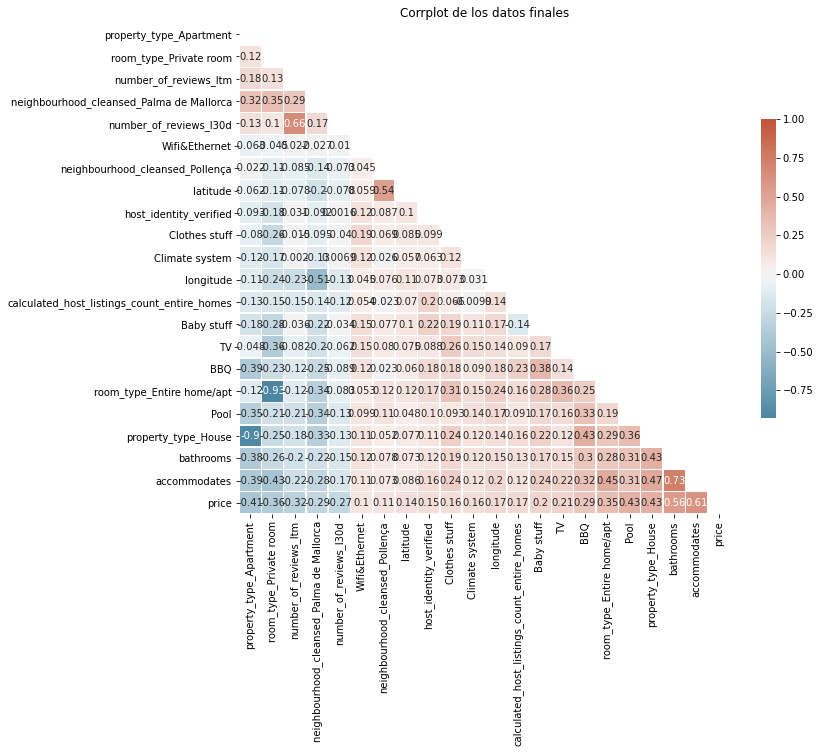

In [63]:
corr = df_datos_tercer_filtro.corr()

plot_corrplot(corr, 'Corrplot de los datos finales')

Podemos observar como hay dos parejas de variables muy correlacionadas (con correlación superior a 0,75): *property_type_Apartment* - *property_type_House* y *room_type_Entire home/apt* - *room_type_Private room*. De estas 4 variables nos vamos a quedar con *property_type_House* y con *room_type_Private room* ya que son las que estan más correlacionadas con el precio:

In [64]:
df_datos_cuarto_filtro = df_datos_tercer_filtro.drop(labels=['property_type_Apartment','room_type_Entire home/apt'], axis=1)

### 1.4-Eliminación de valores nulos

In [65]:
df_datos_cuarto_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15272 entries, 0 to 17607
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   room_type_Private room                       15272 non-null  uint8  
 1   number_of_reviews_ltm                        15272 non-null  int64  
 2   neighbourhood_cleansed_Palma de Mallorca     15272 non-null  uint8  
 3   number_of_reviews_l30d                       15272 non-null  int64  
 4   Wifi&Ethernet                                15272 non-null  int64  
 5   neighbourhood_cleansed_Pollença              15272 non-null  uint8  
 6   latitude                                     15272 non-null  float64
 7   host_identity_verified                       15270 non-null  float64
 8   Clothes stuff                                15272 non-null  int64  
 9   Climate system                               15272 non-null  int64  
 10

Como podemos observar con la limpieza de datos realizada hemos obtenido un *dataframe* de 20 columnas, 15272 filas, con variables no redundantes, con una correlación aceptable con el precio y totalmente numéricas. Además casi hemos conseguido alcanzar el objetivo propuesto en el apartado 1.1: la eliminación de los valores nulos. Como habíamos adelantado antes, la eliminación de las columnas no interesantes para el trabajo (más el estudio de *outliers*) ha hecho llevado implícitamente una drásticamente reducción de la cantidad de valores nulos de los datos. Así pues ahora podemos proceder a eliminar estos valores sin preocuparnos de eliminar todo el dataset en el proceso: 

In [66]:
df_datos_limpios = df_datos_cuarto_filtro.dropna()

In [67]:
df_datos_limpios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15249 entries, 0 to 17607
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   room_type_Private room                       15249 non-null  uint8  
 1   number_of_reviews_ltm                        15249 non-null  int64  
 2   neighbourhood_cleansed_Palma de Mallorca     15249 non-null  uint8  
 3   number_of_reviews_l30d                       15249 non-null  int64  
 4   Wifi&Ethernet                                15249 non-null  int64  
 5   neighbourhood_cleansed_Pollença              15249 non-null  uint8  
 6   latitude                                     15249 non-null  float64
 7   host_identity_verified                       15249 non-null  float64
 8   Clothes stuff                                15249 non-null  int64  
 9   Climate system                               15249 non-null  int64  
 10

In [68]:
df_datos_limpios.describe()

,room_type_Private room,number_of_reviews_ltm,neighbourhood_cleansed_Palma de Mallorca,number_of_reviews_l30d,Wifi&Ethernet,neighbourhood_cleansed_Pollença,latitude,host_identity_verified,Clothes stuff,Climate system,longitude,calculated_host_listings_count_entire_homes,Baby stuff,TV,BBQ,Pool,property_type_House,bathrooms,accommodates,price
count,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000
mean,0.100597,2.280740,0.115942,0.278838,0.936848,0.129910,39.657674,0.829497,0.934750,0.893304,2.999730,96.614598,0.552299,0.918355,0.440422,0.632566,0.674864,1.969113,5.381140,168.883028
std,0.300804,4.948496,0.320166,0.743738,0.243244,0.336216,0.166289,0.376086,0.246975,0.308736,0.241538,209.296313,0.497274,0.273832,0.496454,0.482122,0.468441,1.027317,2.360188,85.031075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.301970,0.000000,0.000000,0.000000,2.346500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.545660,1.000000,1.000000,1.000000,2.838970,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,100.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.671570,1.000000,1.000000,1.000000,3.049490,10.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,6.000000,160.000000
75%,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,39.798090,1.000000,1.000000,1.000000,3.146220,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,227.000000
max,1.000000,74.000000,1.000000,11.000000,1.000000,1.000000,39.922120,1.000000,1.000000,1.000000,3.473150,906.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,16.000000,375.000000


El resultado es un *dataframe* muy limpio compuesto por: 15249 filas, 20 columnas, todos los datos numéricos, con ninguna variable redundante, con todas las *features* con una correlación decente con el objetivo y sin ningún valor nulo. ¡Ahora podemos pasar a entrenar modelos y testearlos!

## 2-Preprocesamiento

### 2.1-Separación del dataset en train y test

Una vez limpiados los datos debemos usarlos para entrenar un modelo de *Machine Learning*. Sin embargo si solo entrenamos el modelo no sabremos como de bueno es. Puede que lo entrenemos y no consigamos que el modelo sea suficientemente flexible como para poder representar la función real que intentamos aproximar, es decir que suframos *underfitting*. O, también, es posible que lo entrenemos y el modelo sea tan flexible que en vez de aproximarse a la función real se "aprenda" el set de datos de entreno de memoria y, por tanto, sea imposible generalizar fuera de nuestro dataset de entreno, es decir que suframos *overfitting*.

Para evitar estos dos problemas lo que debemos hacer es separar nuestro *dataset* en dos *sub-datasets*: uno de entrenamiento y otro de testeo. Como bien indica el nombre con el *dataset* de entreno entrenaremos el modelo y con el de testeo lo pondremos a prueba para descubrir si hay *underfitting* o *overfitting*. Como no tenemos un conjunto de datos muy grande no podemos destinar muchos datos al testeo, por tanto realizaremos la división (obviamente aleatoria) con los siguientes pesos: el 80% de los datos se utilizarán para entrenar y el 20% restante para testear. Sin embargo, esta técnica solo sirve para hacer una estimación rápida del rendimiento del modelo, para acabar de asegurarnos que el modelo funcióna correctamente deberemos realizar una validación cruzada (*cross-validation*). 

In [69]:
# Del dataset limpio cogemos los inputs:
X_total = df_datos_limpios.drop(labels=['price'], axis=1)
X_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15249 entries, 0 to 17607
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   room_type_Private room                       15249 non-null  uint8  
 1   number_of_reviews_ltm                        15249 non-null  int64  
 2   neighbourhood_cleansed_Palma de Mallorca     15249 non-null  uint8  
 3   number_of_reviews_l30d                       15249 non-null  int64  
 4   Wifi&Ethernet                                15249 non-null  int64  
 5   neighbourhood_cleansed_Pollença              15249 non-null  uint8  
 6   latitude                                     15249 non-null  float64
 7   host_identity_verified                       15249 non-null  float64
 8   Clothes stuff                                15249 non-null  int64  
 9   Climate system                               15249 non-null  int64  
 10

In [70]:
# Del dataset limpio cogemos los objetivos deseados:
y_total = pd.DataFrame(df_datos_limpios['price'])
y_total

,price
0,89.0
1,175.0
2,140.0
3,200.0
4,110.0
...,...
17603,195.0
17604,110.0
17605,179.0
17606,42.0


In [71]:
# Separamos en datasetes de entrenamiento y testeo:
tamano_testeo = 0.2
X_entreno, X_test, y_entreno, y_test = train_test_split(X_total, y_total, test_size = tamano_testeo, random_state = 42)

Comprobamos que el dataset se ha dividido con los pesos correspondientes y que la distribución de los datos en los dos *sub-datasets* son similares:

In [72]:
X_entreno.describe()

,room_type_Private room,number_of_reviews_ltm,neighbourhood_cleansed_Palma de Mallorca,number_of_reviews_l30d,Wifi&Ethernet,neighbourhood_cleansed_Pollença,latitude,host_identity_verified,Clothes stuff,Climate system,longitude,calculated_host_listings_count_entire_homes,Baby stuff,TV,BBQ,Pool,property_type_House,bathrooms,accommodates
count,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000,12199.000000
mean,0.101484,2.276416,0.116567,0.278629,0.938110,0.130421,39.657665,0.832937,0.935896,0.894745,2.999678,96.591278,0.553816,0.919010,0.441594,0.636446,0.675465,1.970243,5.384786
std,0.301981,4.953993,0.320917,0.744435,0.240966,0.336779,0.165965,0.373047,0.244947,0.306894,0.241882,209.131199,0.497116,0.272831,0.496597,0.481042,0.468220,0.997299,2.362601
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.301970,0.000000,0.000000,0.000000,2.348320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.545840,1.000000,1.000000,1.000000,2.838740,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.672030,1.000000,1.000000,1.000000,3.048870,10.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,6.000000
75%,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,39.797295,1.000000,1.000000,1.000000,3.146625,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000
max,1.000000,74.000000,1.000000,11.000000,1.000000,1.000000,39.920860,1.000000,1.000000,1.000000,3.473150,906.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,16.000000


In [73]:
X_entreno.shape

(12199, 19)

In [74]:
X_test.describe()

,room_type_Private room,number_of_reviews_ltm,neighbourhood_cleansed_Palma de Mallorca,number_of_reviews_l30d,Wifi&Ethernet,neighbourhood_cleansed_Pollença,latitude,host_identity_verified,Clothes stuff,Climate system,longitude,calculated_host_listings_count_entire_homes,Baby stuff,TV,BBQ,Pool,property_type_House,bathrooms,accommodates
count,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.00000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000
mean,0.097049,2.298033,0.113443,0.279672,0.931803,0.127869,39.657714,0.815738,0.930164,0.887541,2.999940,96.707869,0.54623,0.915738,0.435738,0.617049,0.672459,1.964590,5.366557
std,0.296073,4.927220,0.317185,0.741065,0.252125,0.333998,0.167607,0.387762,0.254912,0.315982,0.240199,209.989761,0.49794,0.277826,0.495934,0.486186,0.469393,1.139668,2.350843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.311480,0.000000,0.000000,0.000000,2.346500,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.545602,1.000000,1.000000,1.000000,2.840048,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.669555,1.000000,1.000000,1.000000,3.053680,9.000000,1.00000,1.000000,0.000000,1.000000,1.000000,2.000000,6.000000
75%,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,39.802098,1.000000,1.000000,1.000000,3.144553,91.000000,1.00000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000
max,1.000000,58.000000,1.000000,11.000000,1.000000,1.000000,39.922120,1.000000,1.000000,1.000000,3.470520,906.000000,1.00000,1.000000,1.000000,1.000000,1.000000,32.000000,16.000000


In [75]:
X_test.shape

(3050, 19)

### 2.2-Escalado de datos

Escalamos los datos para que todas las *features* actuales y futuras tengan la misma escala:

In [76]:
scaler = StandardScaler()
X_entreno_escalado = scaler.fit_transform(X_entreno)
y_entreno_escalado = scaler.fit_transform(y_entreno)
X_test_escalado = scaler.fit_transform(X_test)
y_test_escalado = scaler.fit_transform(y_test)
X_total_escalado = scaler.fit_transform(X_total)
y_total_escalado = scaler.fit_transform(y_total)

**NOTA:** Para el escalado hemos usado estanderizador de características lo que significa que hemos eliminado la media (media = 0) y hemos escalado la varianza a la unidad.


### 2.3-Reducción de dimensionalidad

Vamos a estudiar la posibilidad de reducir el número de dimensiones. Para ello utilizaremos el algoritmo de *Principal Components Analysis* (PCA) e intentaremos preservar el 95% de la información de nuestro dataset.

In [77]:
pca = PCA(0.95)

In [78]:
pca.fit(X_entreno_escalado)

PCA(n_components=0.95)

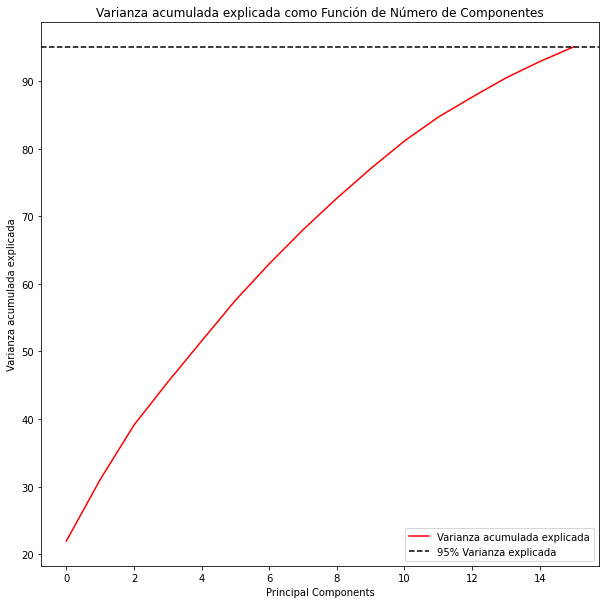

In [79]:
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
d = [n for n in range(len(cumsum))]
plt.figure(figsize = (10, 10))
plt.plot(d, cumsum, color = 'red',label = 'Varianza acumulada explicada')
plt.title('Varianza acumulada explicada como Función de Número de Componentes')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Principal Components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Varianza explicada')
plt.legend(loc='best')

In [80]:
pca.n_components_

16

Como podemos observar la reducción realizado por la PCA no es muy significativa, por tanto vamos a entrenar el modelo sin PCA.

## 3-Selección de métricas

La métrica seleccionada para verificar el correcto funcionamiento de los modelos será la media del error al cuadrado (*Mean Squared Error*). La cual se calcula de la siguiente manera:
$$ MSE = \frac{1}{m}\sum_j^m \left[f(X_{j \cdot}) - y_j\right]^2 $$
Hemos seleccionado esta métrica porque queremos dar más peso a los errores grandes ya que si nos equivocamos de 1 o 2 dólares no es muy preocupante, sin embargo si la predicción se equivoca de 20 o 30 doláres si que podría ser más problemático (el propietario podría estar perdiendo clientes o dinero).

## 4-Modelos

### 4.1-Modelo base: Regresión lineal

La regresión lineal intenta minimizar la suma residual de los cuadrados entre los objetivos observados en el conjunto de datos y los objetivos predichos por una aproximación lineal. No tiene hiper-parámetros para ajustar.

In [206]:
regresion_lineal = linear_model.LinearRegression()
regresion_lineal.fit(X_entreno_escalado, y_entreno_escalado)

LinearRegression()

#### 4.1.1-Entrenamiento

In [272]:
resultados_reg_lineal_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, regresion_lineal, "Regresión lineal", "Entrenamiento" )

MSE de Regresión lineal en Entrenamiento: 0.49086905253141117


#### 4.1.2-Test

In [273]:
resultados_reg_lineal_test = predecir_precio(X_test_escalado, y_test_escalado, regresion_lineal, "Regresión lineal", "Test" )

MSE de Regresión lineal en Test: 0.4945423063045337


#### 4.1.3-Cross-validation

In [274]:
resultados_reg_lineal_cross_val = cross_validate_farm(X_total_escalado, y_total_escalado, linear_model.LinearRegression(), "Regresión lineal", 5)

MSE de Regresión lineal en cross validation: 0.49935272 +- 0.03914179


In [275]:
resultados_regresion_lineal = pd.concat([resultados_reg_lineal_entrenamiento, resultados_reg_lineal_test, resultados_reg_lineal_cross_val], axis = 1)
resultados_regresion_lineal.head()

,Entrenamiento,Test,Cross validation
Regresión lineal,0.490869,0.494542,0.499353


Como podemos observar el modelo no sufre de *overfitting* ya que tanto el resultado de test como el de la validación cruzada es casi igual al resultado del entrenamiento. Sin embargo, 
hay mucho error ya que la media del error al cuadrado en todos los casos es muy alta, casi de 0,5, por tanto sufrimos *underfitting*. Así que lo que necesitamos, a partir de ahora, es probar modelos con una mayor flexibilidad.

### 4.2-Árbol de decisión

El árbol de decisión es un modelo de Machine Learning supervisado no paramétrico el cual predice el valor de un objetivo mediante el aprendizaje de sencillas reglas de decisión inferidas de las caracterísiticas de los datos.

Este modelo sí tiene hiper-parámetros que ajustar (nosotros jugaremos con *max_depth* y con *max_features*), para realizar esta tarea utilizaremos un *GridSearch*:

In [212]:
# Vamos a mirar los siguientes hiper-parámetros:
Parametros = [{'max_depth': range(1, 20), 'max_features': ['auto', 'sqrt', 'log2']}]


# Buscamos el mejor modelo para entrenar estos datos mirando la métrica neg_mean_squared_error
seleccion_arbol_decisión = GridSearchCV(tree.DecisionTreeRegressor(), Parametros, scoring = 'neg_mean_squared_error')

#Entrenamos el modelo:
seleccion_arbol_decisión.fit(X_entreno_escalado, y_entreno_escalado.ravel())

# Imprimimos los resultados:
print()
print("Todas las posibles opciones:")
print()
medias = seleccion_arbol_decisión.cv_results_['mean_test_score']
varianzas = seleccion_arbol_decisión.cv_results_['std_test_score']
for media, varianza, params in zip(medias, varianzas, seleccion_arbol_decisión.cv_results_['params']):
   print("%0.3f (+/-%0.03f) for %r" % (media, varianza * 2, params))
print()
print("Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:")
print()
print(seleccion_arbol_decisión.best_params_)


Todas las posibles opciones:

-0.695 (+/-0.017) for {'max_depth': 1, 'max_features': 'auto'}
-0.834 (+/-0.176) for {'max_depth': 1, 'max_features': 'sqrt'}
-0.858 (+/-0.200) for {'max_depth': 1, 'max_features': 'log2'}
-0.600 (+/-0.018) for {'max_depth': 2, 'max_features': 'auto'}
-0.656 (+/-0.084) for {'max_depth': 2, 'max_features': 'sqrt'}
-0.663 (+/-0.170) for {'max_depth': 2, 'max_features': 'log2'}
-0.549 (+/-0.017) for {'max_depth': 3, 'max_features': 'auto'}
-0.604 (+/-0.073) for {'max_depth': 3, 'max_features': 'sqrt'}
-0.591 (+/-0.049) for {'max_depth': 3, 'max_features': 'log2'}
-0.518 (+/-0.015) for {'max_depth': 4, 'max_features': 'auto'}
-0.615 (+/-0.038) for {'max_depth': 4, 'max_features': 'sqrt'}
-0.580 (+/-0.067) for {'max_depth': 4, 'max_features': 'log2'}
-0.493 (+/-0.014) for {'max_depth': 5, 'max_features': 'auto'}
-0.561 (+/-0.103) for {'max_depth': 5, 'max_features': 'sqrt'}
-0.560 (+/-0.055) for {'max_depth': 5, 'max_features': 'log2'}
-0.480 (+/-0.024) for {'

In [213]:
arbol_decision = tree.DecisionTreeRegressor(max_depth = seleccion_arbol_decisión.best_params_['max_depth'], max_features = seleccion_arbol_decisión.best_params_['max_features'])
arbol_decision.fit(X_entreno_escalado, y_entreno_escalado)

DecisionTreeRegressor(max_depth=8, max_features='auto')

#### 4.2.1-Entrenamiento

In [219]:
resultados_arb_decision_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, arbol_decision, "Árbol de decisión", "Entrenamiento" )

MSE de Árbol de decisión en Entrenamiento: 0.392862478179932


#### 4.2.2-Test

In [220]:
resultados_arb_decision_test = predecir_precio(X_test_escalado, y_test_escalado, arbol_decision, "Árbol de decisión", "Test" )

MSE de Árbol de decisión en Test: 0.47650429270081524


#### 4.2.3-Cross-validation

In [221]:
resultados_arb_decision_cross_val= cross_validate_farm(X_total_escalado, y_total_escalado, tree.DecisionTreeRegressor(max_depth = seleccion_arbol_decisión.best_params_['max_depth'], max_features = seleccion_arbol_decisión.best_params_['max_features']), "Árbol de decisión", 5)

MSE de Árbol de decisión en cross validation: 0.50127294 +- 0.04284592


In [222]:
resultados_arbol_decision = pd.concat([resultados_arb_decision_entrenamiento, resultados_arb_decision_test, resultados_arb_decision_cross_val], axis = 1)
resultados_arbol_decision.head()

,Entrenamiento,Test,Cross validation
Árbol de decisión,0.392862,0.476504,0.501273


Como podemos ver aunque usemos un modelo más flexible (y con hiper-parámetros ajustados) no conseguimos dejar de tener *overfitting* (ya que la media del error cuadrático medio tanto en test como en la validación cruzada es 0,5 o muy cercano a 0,5). Por tanto necesitamos seguir buscando un modelo más flexible y complejo.

### 4.3-RandomForestRegressor

El modelo de bosques aleatorios genera una serie de árboles de decisión y a cada arbol le asigna un sub-conjunto de los datos. Luego utiliza promedios para mejorar la precisión predictiva y controlar el *overfitting*.

Este modelo también tiene hiper-parámetros que ajustar (nosotros tocaremos *max_depth* y *max_features*), para realizar esta tarea utilizaremos un *GridSearch*:

In [125]:
# Vamos a mirar los siguientes hiper-parámetros:
Parametros = [{'max_depth': range(1, 20), 'max_features': ['auto', 'sqrt', 'log2']}]

# Buscamos el mejor modelo para entrenar estos datos mirando la métrica neg_mean_squared_error
seleccion_RandomForestRegressor = GridSearchCV(RandomForestRegressor(), Parametros, scoring = 'neg_mean_squared_error')

#Entrenamos el modelo:
seleccion_RandomForestRegressor.fit(X_entreno_escalado, y_entreno_escalado.ravel())

# Imprimimos los resultados:
print()
print("Todas las posibles opciones:")
print()
medias = seleccion_RandomForestRegressor.cv_results_['mean_test_score']
varianzas = seleccion_RandomForestRegressor.cv_results_['std_test_score']
for media, varianza, params in zip(medias, varianzas, seleccion_RandomForestRegressor.cv_results_['params']):
   print("%0.3f (+/-%0.03f) for %r" % (media, varianza * 2, params))
print()
print("Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:")
print()
print(seleccion_RandomForestRegressor.best_params_)


Todas las posibles opciones:

-0.688 (+/-0.019) for {'max_depth': 1, 'max_features': 'auto'}
-0.696 (+/-0.037) for {'max_depth': 1, 'max_features': 'sqrt'}
-0.690 (+/-0.029) for {'max_depth': 1, 'max_features': 'log2'}
-0.580 (+/-0.020) for {'max_depth': 2, 'max_features': 'auto'}
-0.584 (+/-0.024) for {'max_depth': 2, 'max_features': 'sqrt'}
-0.583 (+/-0.034) for {'max_depth': 2, 'max_features': 'log2'}
-0.530 (+/-0.017) for {'max_depth': 3, 'max_features': 'auto'}
-0.531 (+/-0.018) for {'max_depth': 3, 'max_features': 'sqrt'}
-0.532 (+/-0.014) for {'max_depth': 3, 'max_features': 'log2'}
-0.494 (+/-0.017) for {'max_depth': 4, 'max_features': 'auto'}
-0.498 (+/-0.016) for {'max_depth': 4, 'max_features': 'sqrt'}
-0.499 (+/-0.013) for {'max_depth': 4, 'max_features': 'log2'}
-0.470 (+/-0.015) for {'max_depth': 5, 'max_features': 'auto'}
-0.478 (+/-0.018) for {'max_depth': 5, 'max_features': 'sqrt'}
-0.478 (+/-0.016) for {'max_depth': 5, 'max_features': 'log2'}
-0.453 (+/-0.017) for {'

In [223]:
random_forest_regressor = RandomForestRegressor(max_depth = seleccion_RandomForestRegressor.best_params_['max_depth'], max_features = seleccion_RandomForestRegressor.best_params_['max_features'])
random_forest_regressor.fit(X_entreno_escalado, y_entreno_escalado.ravel())

RandomForestRegressor(max_depth=18, max_features='sqrt')

#### 4.3.1-Entrenamiento

In [228]:
random_forest_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, random_forest_regressor, "Random Forest Regressor", "Entrenamiento" )

MSE de Random Forest Regressor en Entrenamiento: 0.13416850597446214


#### 4.3.2-Test

In [229]:
random_forest_test = predecir_precio(X_test_escalado, y_test_escalado, random_forest_regressor, "Random Forest Regressor", "Test" )

MSE de Random Forest Regressor en Test: 0.37687927675024574


#### 4.3.3-Cross-validation

In [230]:
random_forest_cross_val = cross_validate_farm(X_total_escalado, y_total_escalado, RandomForestRegressor(max_depth = seleccion_RandomForestRegressor.best_params_['max_depth'], max_features = seleccion_RandomForestRegressor.best_params_['max_features']), "Random Forest Regressor", 5)

MSE de Random Forest Regressor en cross validation: 0.42517284 +- 0.04192428


In [231]:
resultados_random_forest = pd.concat([random_forest_entrenamiento, random_forest_test, random_forest_cross_val], axis = 1)
resultados_random_forest.head()

,Entrenamiento,Test,Cross validation
Random Forest Regressor,0.134169,0.376879,0.425173


Con este modelo podemos observar una cierta mejora del error cuadrático medio en los tres casos (entrenamiento, test y validación cruzada), sin embargo los resultados aún no son muy buenos.

Además cabe recalcar que parece que el modelo tiene *overfitting* ya que hay bastante diferencia entre los resultados del entrenamiento y los de testeo/validación cruzada.

### 4.4-Máquina de vectores de soporte

NO EJECUTAR EL GRID SEARCH, TARDA DEMASIADO. LOS MEJORES HIPER-PARÉMTREOS SON: KERNEL = 'rbf' Y C = 1.

In [86]:
# Vamos a mirar los siguientes hiper-parámetros:
#Parametros = [{'kernel': ['rbf', 'linear'], 'C': [1, 10]}] 

# Buscamos el mejor modelo para entrenar estos datos mirando la métrica neg_mean_squared_error
#seleccion_SVM = GridSearchCV(svm.SVR(), Parametros, scoring = 'neg_mean_squared_error')

#Entrenamos el modelo:
#seleccion_SVM.fit(X_entreno_escalado, y_entreno_escalado.ravel())

# Imprimimos los resultados:
#print()
#print("Todas las posibles opciones:")
#print()
#medias = seleccion_SVM.cv_results_['mean_test_score']
#varianzas = seleccion_SVM.cv_results_['std_test_score']
#for media, varianza, params in zip(medias, varianzas, seleccion_SVM.cv_results_['params']):
   #print("%0.3f (+/-%0.03f) for %r" % (media, varianza * 2, params))
#print()
#print("Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:")
#print()
#print(seleccion_SVM.best_params_)


Todas las posibles opciones:

-0.438 (+/-0.025) for {'C': 1, 'kernel': 'rbf'}
-0.501 (+/-0.032) for {'C': 1, 'kernel': 'linear'}
-0.456 (+/-0.017) for {'C': 10, 'kernel': 'rbf'}
-0.501 (+/-0.032) for {'C': 10, 'kernel': 'linear'}

Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:

{'C': 1, 'kernel': 'rbf'}


In [87]:
#regresion_svm = svm.SVR(kernel = seleccion_SVM.best_params_['kernel'], C = seleccion_SVM.best_params_['C'])
#regresion_svm.fit(X_entreno_escalado, y_entreno_escalado.ravel())

SVR(C=1)

In [232]:
regresion_svm = svm.SVR(kernel = 'rbf', C = 1)
regresion_svm.fit(X_entreno_escalado, y_entreno_escalado.ravel())

SVR(C=1)

#### 4.4.1-Entrenamiento

In [260]:
SVM_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, regresion_svm, "Máquina de vectores de soporte", "Entrenamiento" )

MSE de Máquina de vectores de soporte en Entrenamiento: 0.38476714754274827


#### 4.4.2-Test

In [261]:
SVM_test = predecir_precio(X_test_escalado, y_test_escalado, regresion_svm, "Máquina de vectores de soporte", "Test" )

MSE de Máquina de vectores de soporte en Test: 0.42167848484343534


#### 4.4.3-Cross validate

In [262]:
SVM_cross_val = cross_validate_farm(X_total_escalado, y_total_escalado, svm.SVR(), "Máquina de vectores de soporte", 5)

MSE de Máquina de vectores de soporte en cross validation: 0.45801433 +- 0.04462218


In [263]:
resultados_SVM = pd.concat([SVM_entrenamiento, SVM_test, SVM_cross_val], axis = 1)
resultados_SVM.head()

,Entrenamiento,Test,Cross validation
Máquina de vectores de soporte,0.384767,0.421678,0.458014


En el caso de la máquina de vectores de soporte podemos observar que los resultados son mejores que en el caso de la regresión lineal y del árbol de decisión pero, tampoco son muy buenos y no superan a los del RandomForestRegressor.  

### 4.5-Lasso

El modelo Lasso es un modelo lineal pensado para realizar regresiones con pocos coeficientes distintos a cero, reduciendo así el número de caracterísiticas de las que depende la solución dada. 

Este modelo también tiene hiper-parámetros que pueden ser ajustados. Nosotros buscaremos la mejor combinación de los hiper-parámetros *alpha* y *selection* con un *GridSearch*:

In [240]:
# Vamos a mirar los siguientes hiper-parámetros:
Parametros = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1], 'selection': ['cyclic', 'random']}]

# Buscamos el mejor modelo para entrenar estos datos mirando la métrica neg_mean_squared_error
seleccion_Lasso = GridSearchCV(linear_model.Lasso(), Parametros, scoring = 'neg_mean_squared_error')

#Entrenamos el modelo:
seleccion_Lasso.fit(X_entreno_escalado, y_entreno_escalado.ravel())

# Imprimimos los resultados:
print()
print("Todas las posibles opciones:")
print()
medias = seleccion_Lasso.cv_results_['mean_test_score']
varianzas = seleccion_Lasso.cv_results_['std_test_score']
for media, varianza, params in zip(medias, varianzas, seleccion_Lasso.cv_results_['params']):
   print("%0.3f (+/-%0.03f) for %r" % (media, varianza * 2, params))
print()
print("Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:")
print()
print(seleccion_Lasso.best_params_)


Todas las posibles opciones:

-0.493 (+/-0.033) for {'alpha': 0.0001, 'selection': 'cyclic'}
-0.493 (+/-0.033) for {'alpha': 0.0001, 'selection': 'random'}
-0.493 (+/-0.033) for {'alpha': 0.001, 'selection': 'cyclic'}
-0.493 (+/-0.033) for {'alpha': 0.001, 'selection': 'random'}
-0.495 (+/-0.032) for {'alpha': 0.01, 'selection': 'cyclic'}
-0.495 (+/-0.032) for {'alpha': 0.01, 'selection': 'random'}
-0.529 (+/-0.028) for {'alpha': 0.1, 'selection': 'cyclic'}
-0.529 (+/-0.028) for {'alpha': 0.1, 'selection': 'random'}
-0.643 (+/-0.040) for {'alpha': 0.25, 'selection': 'cyclic'}
-0.643 (+/-0.040) for {'alpha': 0.25, 'selection': 'random'}
-0.879 (+/-0.057) for {'alpha': 0.5, 'selection': 'cyclic'}
-0.879 (+/-0.056) for {'alpha': 0.5, 'selection': 'random'}
-1.000 (+/-0.056) for {'alpha': 0.75, 'selection': 'cyclic'}
-1.000 (+/-0.056) for {'alpha': 0.75, 'selection': 'random'}
-1.000 (+/-0.056) for {'alpha': 1, 'selection': 'cyclic'}
-1.000 (+/-0.056) for {'alpha': 1, 'selection': 'random

In [241]:
regresion_Lasso = linear_model.Lasso(alpha = seleccion_Lasso.best_params_['alpha'], selection = seleccion_Lasso.best_params_['selection'])
regresion_Lasso.fit(X_entreno_escalado, y_entreno_escalado.ravel())

Lasso(alpha=0.001, selection='random')

#### 4.5.1-Entrenamiento

In [244]:
Lasso_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, regresion_Lasso, "Lasso", "Entrenamiento" )

MSE de Lasso en Entrenamiento: 0.4908941976113784


#### 4.5.2-Test

In [245]:
Lasso_test = predecir_precio(X_test_escalado, y_test_escalado, regresion_Lasso, "Lasso", "Test" )

MSE de Lasso en Test: 0.49470279483844515


#### 4.5.3-Cross Validation

In [247]:
Lasso_cross_val = cross_validate_farm(X_total_escalado, y_total_escalado, linear_model.Lasso(alpha = seleccion_Lasso.best_params_['alpha'], selection = seleccion_Lasso.best_params_['selection']), "Lasso", 5)

MSE de Lasso en cross validation: 0.49933669 +- 0.03918543


In [248]:
resultados_Lasso = pd.concat([Lasso_entrenamiento, Lasso_test, Lasso_cross_val], axis = 1)
resultados_Lasso.head()

,Entrenamiento,Test,Cross validation
Lasso,0.490894,0.494703,0.499337


Como podemos observar el modelo Lasso también sufre *underfitting* y por lo tanto tampoco da un buen resultado.

### 4.6-GradientBoostingRegressor

El modelo de Gradient Boosting Regressor construye un modelo aditivo de manera progresiva por etapas de esta manera permite la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa se ajusta un árbol de regresión sobre el gradiente negativo de la función de pérdida dada.

Los hiper-parámetro que ajustaremos, mediante un *GridSearch*, en este caso serán: *loss*, *learning_rate* y *max_features*.

In [249]:
# Vamos a mirar los siguientes hiper-parámetros:
Parametros = [{'loss': ['ls', 'lad', 'huber'], 'learning_rate': [0.1, 0.2, 0.3, 0.4], 'max_features': ['auto', 'sqrt', 'log2'] }]

# Buscamos el mejor modelo para entrenar estos datos mirando la métrica neg_mean_squared_error
seleccion_GradientBoostingRegressor = GridSearchCV(GradientBoostingRegressor(), Parametros, scoring = 'neg_mean_squared_error')

#Entrenamos el modelo:
seleccion_GradientBoostingRegressor.fit(X_entreno_escalado, y_entreno_escalado.ravel())

# Imprimimos los resultados:
print()
print("Todas las posibles opciones:")
print()
medias = seleccion_GradientBoostingRegressor.cv_results_['mean_test_score']
varianzas = seleccion_GradientBoostingRegressor.cv_results_['std_test_score']
for media, varianza, params in zip(medias, varianzas, seleccion_GradientBoostingRegressor.cv_results_['params']):
   print("%0.3f (+/-%0.03f) for %r" % (media, varianza * 2, params))
print()
print("Las mejores opciones para el dataset teniendo en cuenta la precision del modelo son:")
print()
print(seleccion_GradientBoostingRegressor.best_params_)


Todas las posibles opciones:

-0.420 (+/-0.016) for {'learning_rate': 0.1, 'loss': 'ls', 'max_features': 'auto'}
-0.432 (+/-0.017) for {'learning_rate': 0.1, 'loss': 'ls', 'max_features': 'sqrt'}
-0.433 (+/-0.019) for {'learning_rate': 0.1, 'loss': 'ls', 'max_features': 'log2'}
-0.436 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'lad', 'max_features': 'auto'}
-0.444 (+/-0.021) for {'learning_rate': 0.1, 'loss': 'lad', 'max_features': 'sqrt'}
-0.445 (+/-0.022) for {'learning_rate': 0.1, 'loss': 'lad', 'max_features': 'log2'}
-0.420 (+/-0.015) for {'learning_rate': 0.1, 'loss': 'huber', 'max_features': 'auto'}
-0.433 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'huber', 'max_features': 'sqrt'}
-0.432 (+/-0.017) for {'learning_rate': 0.1, 'loss': 'huber', 'max_features': 'log2'}
-0.403 (+/-0.017) for {'learning_rate': 0.2, 'loss': 'ls', 'max_features': 'auto'}
-0.419 (+/-0.016) for {'learning_rate': 0.2, 'loss': 'ls', 'max_features': 'sqrt'}
-0.417 (+/-0.020) for {'learning_rate': 0.2,

In [276]:
regresion_gradient_boosting = GradientBoostingRegressor(loss = seleccion_GradientBoostingRegressor.best_params_['loss'], learning_rate = seleccion_GradientBoostingRegressor.best_params_['learning_rate'], max_features = seleccion_GradientBoostingRegressor.best_params_['max_features'])
regresion_gradient_boosting.fit(X_entreno_escalado, y_entreno_escalado.ravel())

GradientBoostingRegressor(learning_rate=0.4, max_features='auto')

#### 4.6.1-Entrenamiento

In [277]:
GBR_entrenamiento = predecir_precio(X_entreno_escalado, y_entreno_escalado, regresion_gradient_boosting, "Gradient Boosting Regressor", "Entrenamiento" )

MSE de Gradient Boosting Regressor en Entrenamiento: 0.3291278274871177


#### 4.6.2-Test

In [278]:
GBR_test = predecir_precio(X_test_escalado, y_test_escalado, regresion_gradient_boosting, "Gradient Boosting Regressor", "Test" )

MSE de Gradient Boosting Regressor en Test: 0.37662960632325


#### 4.6.3-Cross Validation

In [279]:
GBR_cross_val = cross_validate_farm(X_total_escalado, y_total_escalado, GradientBoostingRegressor(loss = seleccion_GradientBoostingRegressor.best_params_['loss'], learning_rate = seleccion_GradientBoostingRegressor.best_params_['learning_rate']), "Gradient Boosting Regressor", 5)

MSE de Gradient Boosting Regressor en cross validation: 0.42570587 +- 0.04340807


In [280]:
resultados_GBR = pd.concat([GBR_entrenamiento, GBR_test, GBR_cross_val], axis = 1)
resultados_GBR.head()

,Entrenamiento,Test,Cross validation
Gradient Boosting Regressor,0.329128,0.37663,0.425706


Finalmente el Gradient Boosting Regressor tiene unos resultados muy similares a los del Random Forest Regressor y junto a este son los dos mejores modelos encontrados. La diferencia más grande entre los dos es que el GBR no tiene *overfitting* (o si lo tiene es bastante bajo) mientras que el RFR sí.

#### 4.7-Resumen de resultados

Podemos observar un resumen de los resultados a continuación: 

In [294]:
resultados = pd.concat([resultados_regresion_lineal, resultados_arbol_decision, resultados_random_forest, resultados_SVM, resultados_Lasso, resultados_GBR], axis = 0)
resultados = resultados.sort_values('Cross validation')
resultados.head(6)

,Entrenamiento,Test,Cross validation
Random Forest Regressor,0.134169,0.376879,0.425173
Gradient Boosting Regressor,0.329128,0.376630,0.425706
Máquina de vectores de soporte,0.384767,0.421678,0.458014
Lasso,0.490894,0.494703,0.499337
Regresión lineal,0.490869,0.494542,0.499353
Árbol de decisión,0.392862,0.476504,0.501273


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6848ebf70>,
      dtype=object)

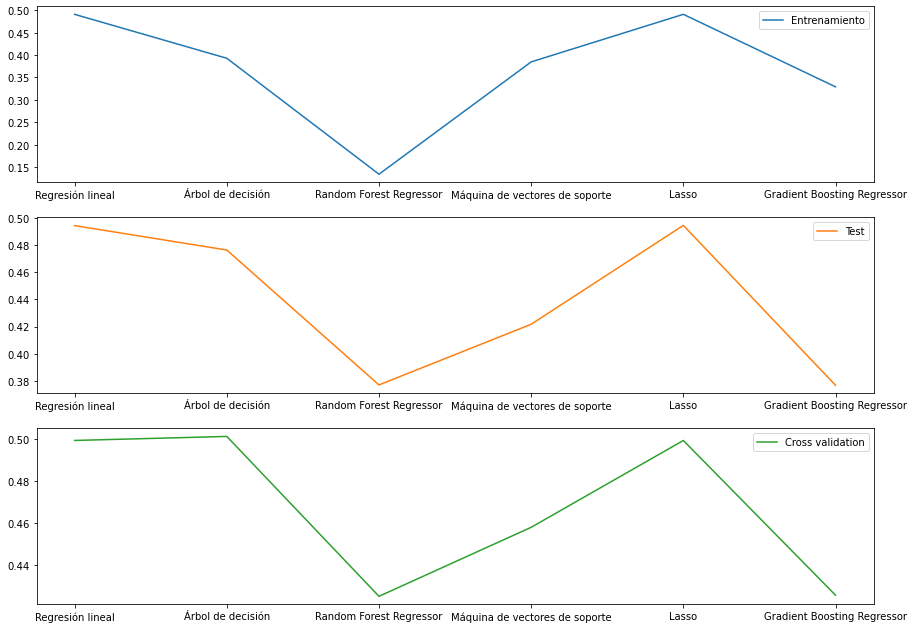

In [293]:
resultados.plot.line(subplots = True, sharex = False, figsize = (15, 11))

Como ya hemos ido adelantando los modelos que predicen mejor estos datos son el *Random Forest Regressor* (con *max_depth* = 18, *max_features* = *sqrt*) y *Gradient Boosting Regressor* (con *learning_rate* = 0.4, *loss* = *ls* y *max_features* = *auto*). Mientras que los peores modelos son: Lasso, la Regresión lineal y el Árbol de decisión.

## 5-Conclusiones

Finalmente y para cerrar este proyecto podemos concluir que aunque hayamos limpiado concienzudamente los datos (mediante un estudio de *outliers*, un estudio de correlación, una eliminación de características irrelevantes y un estudio de los valores nulos) los resultados obtenidos no son tan aceptables como esperábamos. En ningún caso hemos conseguido un modelo que tuviera una media de errores cuadráticos más baja a 0,4 con lo que ninguna de las predicciones que realizan nuestros modelos son muy acertadas. Esto puede ser causa de:
+ La eliminación de alguna variable, en la fase de limpieza de dataset, que pensábamos que era irrelevente pero que en realidad era relevante.
+ Justamente no hemos encontrado el modelo o los hiper-parámetros que consiguen predecir correctamente el precio de los alquileres.
+ Los datos no son suficientemente buenos para conseguir una buena predicción.
